<a href="https://colab.research.google.com/github/AdonyeBrown/B_Airways_prediction/blob/master/pyspark_market_basket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This main process of this note book borrowed from https://www.kaggle.com/code/earije/market-basket-analysis-with-apriori

* [<span style='color:#ff9900'> 1. </span> Loading,Transforming and Cleaning Data](#loading)
* [<span style='color:#ff9900'> 2. </span> Exploratoty Data Analysis](#exploring)
* [<span style='color:#ff9900'> 3. </span> Association Rules Exploring](#Association)
* [<span style='color:#ff9900'> 4. </span> Conclusion](#Conclusion)

<a id="loading"></a>
## <li><span style="color: #ff9900;">1 Loading,Transforming and Cleaning Data</span></li>

### <li><span style="color: #ff9900;">1-1 Loading Data from csv</span></li>

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b26b83d0e24814d2de68918273c433f288841a43274c3e35737b104a45a58f7b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark import SparkContext
from pyspark.sql import functions as F, SparkSession, Column,types
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession.builder.appName("MarketBasketAnalysis").getOrCreate()

In [5]:
data = spark.read.csv("/content/Assignment-1_Data.csv",header=True,sep=";")
data.show(5)

+------+--------------------+--------+----------------+-----+----------+--------------+
|BillNo|            Itemname|Quantity|            Date|Price|CustomerID|       Country|
+------+--------------------+--------+----------------+-----+----------+--------------+
|536365|WHITE HANGING HEA...|       6|01.12.2010 08:26| 2,55|     17850|United Kingdom|
|536365| WHITE METAL LANTERN|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|CREAM CUPID HEART...|       8|01.12.2010 08:26| 2,75|     17850|United Kingdom|
|536365|KNITTED UNION FLA...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|RED WOOLLY HOTTIE...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
+------+--------------------+--------+----------------+-----+----------+--------------+
only showing top 5 rows



In [6]:
data.printSchema()

root
 |-- BillNo: string (nullable = true)
 |-- Itemname: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [7]:
data = data.withColumn("Price",F.regexp_replace("Price",",",""))
data = data.withColumn("Price",F.col("Price").cast("float"))
data = data.withColumn("Quantity",F.col("Quantity").cast("int"))

### <li><span style="color: #ff9900;">1-2 Processing the Datetime columns</span></li>

In [8]:
# Work on Date time
data = data.withColumn("Date_Day",F.split("Date"," ",0)[0])
data = data.withColumn("Date_Time",F.split("Date"," ",0)[1])

data = data.withColumn("Hour",F.split("Date_Time",":")[0])
data = data.withColumn("Minute",F.split("Date_Time",":")[1])
data = data.withColumn("Year",F.split("Date_Day","\.")[2])
data = data.withColumn("Month",F.split("Date_Day","\.")[1])
data = data.withColumn("Day",F.split("Date_Day","\.")[0])

In [9]:
convert_to_Date = F.udf(lambda x:"-".join(x.split(".")[::-1])+" ",types.StringType())

In [10]:
data = data.withColumn("Date",F.concat(convert_to_Date(data["Date_Day"]),data["Date_Time"]))
data = data.withColumn("Date",data["Date"].cast(types.TimestampType()))

In [11]:
data = data.withColumn("DayOfWeek",F.dayofweek(data["Date"])-1) #dayofweek这个函数中，以周日为第一天
data = data.withColumn("DayOfWeek",F.udf(lambda x:x if x!=0 else 7,types.IntegerType())(data["DayOfWeek"]))

In [12]:
data.show(10)

+------+--------------------+--------+-------------------+-----+----------+--------------+----------+---------+----+------+----+-----+---+---------+
|BillNo|            Itemname|Quantity|               Date|Price|CustomerID|       Country|  Date_Day|Date_Time|Hour|Minute|Year|Month|Day|DayOfWeek|
+------+--------------------+--------+-------------------+-----+----------+--------------+----------+---------+----+------+----+-----+---+---------+
|536365|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|255.0|     17850|United Kingdom|01.12.2010|    08:26|  08|    26|2010|   12| 01|        3|
|536365| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|339.0|     17850|United Kingdom|01.12.2010|    08:26|  08|    26|2010|   12| 01|        3|
|536365|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|275.0|     17850|United Kingdom|01.12.2010|    08:26|  08|    26|2010|   12| 01|        3|
|536365|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|339.0|     17850|United Kingdom|01.12.2010|    0

### <li><span style="color: #ff9900;">1-3 Fill null data,Dropping data with negative value and not-product data</span></li>

In [13]:
# filter quauntity by price
data = data.filter((F.col("Price")>0) & (F.col("Quantity")>0))

In [14]:
# create Total Price column
data = data.withColumn("Total Price",F.col("Price")*F.col("Quantity"))

In [15]:
data_null_agg = data.agg(
    *[F.count(F.when(F.isnull(c), c)).alias(c) for c in data.columns])
data_null_agg.show()

+------+--------+--------+----+-----+----------+-------+--------+---------+----+------+----+-----+---+---------+-----------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|Date_Day|Date_Time|Hour|Minute|Year|Month|Day|DayOfWeek|Total Price|
+------+--------+--------+----+-----+----------+-------+--------+---------+----+------+----+-----+---+---------+-----------+
|     0|       0|       0|   0|    0|    131566|      0|       0|        0|   0|     0|   0|    0|  0|        0|          0|
+------+--------+--------+----+-----+----------+-------+--------+---------+----+------+----+-----+---+---------+-----------+



In [16]:
# CustomerID fill
data = data.fillna("99999","CustomerID")

In [17]:
data.show(10)

+------+--------------------+--------+-------------------+-----+----------+--------------+----------+---------+----+------+----+-----+---+---------+-----------+
|BillNo|            Itemname|Quantity|               Date|Price|CustomerID|       Country|  Date_Day|Date_Time|Hour|Minute|Year|Month|Day|DayOfWeek|Total Price|
+------+--------------------+--------+-------------------+-----+----------+--------------+----------+---------+----+------+----+-----+---+---------+-----------+
|536365|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|255.0|     17850|United Kingdom|01.12.2010|    08:26|  08|    26|2010|   12| 01|        3|     1530.0|
|536365| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|339.0|     17850|United Kingdom|01.12.2010|    08:26|  08|    26|2010|   12| 01|        3|     2034.0|
|536365|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|275.0|     17850|United Kingdom|01.12.2010|    08:26|  08|    26|2010|   12| 01|        3|     2200.0|
|536365|KNITTED UNION FLA...|     

In [18]:
# filter Item
data = data.filter((F.col("Itemname")!='POSTAGE') & (F.col("Itemname")!='DOTCOM POSTAGE') & (F.col("Itemname")!='Adjust bad debt') & (F.col("Itemname")!='Manual'))

<a id="exploring"></a>
## <li><span style="color: #ff9900;">2 Exploratoty Data Analysis</span></li>

### <li><span style="color: #ff9900;">2-1 Exploring overall sales</span></li>

In [19]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

In [20]:
## item
data_ttl_trans = data.groupby(["BillNo"]).sum("Quantity","Total Price").withColumnRenamed("sum(Quantity)","Quantity").withColumnRenamed("sum(Total Price)","Total Price").toPandas()
data_ttl_item = data.groupby(["Itemname"]).sum("Quantity","Total Price").withColumnRenamed("sum(Quantity)","Quantity").withColumnRenamed("sum(Total Price)","Total Price").toPandas()
data_ttl_time = data.groupby(["Year","Month"]).sum("Quantity","Total Price").withColumnRenamed("sum(Quantity)","Quantity").withColumnRenamed("sum(Total Price)","Total Price").toPandas()
data_ttl_weekday = data.groupby(["DayOfWeek"]).sum("Quantity","Total Price").withColumnRenamed("sum(Quantity)","Quantity").withColumnRenamed("sum(Total Price)","Total Price").toPandas()
data_ttl_country = data.groupby(["Country"]).sum("Quantity","Total Price").withColumnRenamed("sum(Quantity)","Quantity").withColumnRenamed("sum(Total Price)","Total Price").toPandas()
data_ttl_country_time = data.groupby(["Country","Year","Month"]).sum("Quantity","Total Price").withColumnRenamed("sum(Quantity)","Quantity").withColumnRenamed("sum(Total Price)","Total Price").toPandas()

<Axes: ylabel='Quantity'>

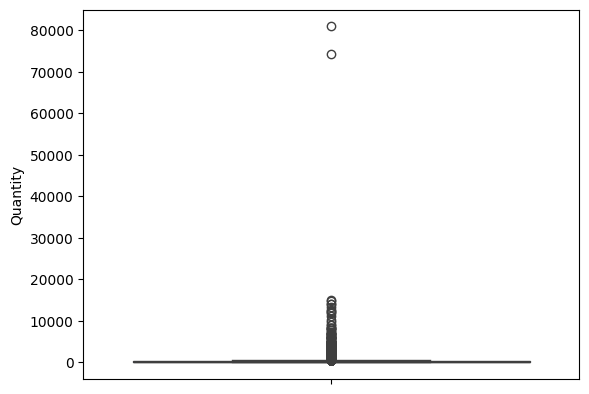

In [21]:
sns.boxplot(data_ttl_trans["Quantity"])

<Axes: ylabel='Total Price'>

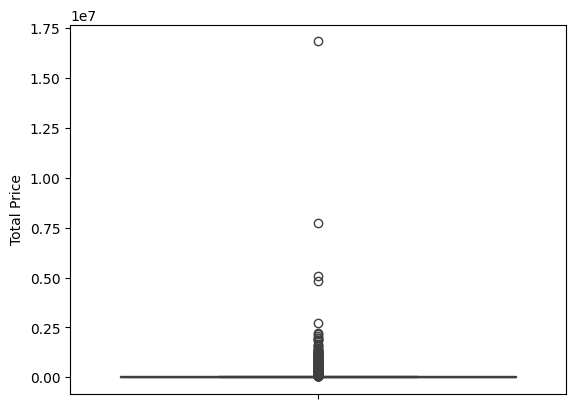

In [22]:
sns.boxplot(data_ttl_trans["Total Price"])

<p><span style="color: #ff9900;">As shown in the two charts above, the sales data are extremely unbalanced, with some sales far exceeding the normal sales.The outliers shown in the boxplot will be removed below.</span></p>

In [23]:
print("Quantity upper",np.percentile(data_ttl_trans["Quantity"],75)*2.5-np.percentile(data_ttl_trans["Quantity"],25)) #箱线图顶点
print("Total Price upper",np.percentile(data_ttl_trans["Total Price"],75)*2.5-np.percentile(data_ttl_trans["Total Price"],25)) #箱线图顶点

Quantity upper 661.75
Total Price upper 97779.0


In [24]:
data_ttl_trans[data_ttl_trans["Quantity"]<=661].shape[0]/data_ttl_trans.shape[0]

0.9332989690721649

In [25]:
data_ttl_trans[data_ttl_trans["Total Price"]<=97779].shape[0]/data_ttl_trans.shape[0]

0.9188144329896907

<ipython-input-26-fcc98703b094>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ttl_trans[data_ttl_trans["Quantity"]<=661]["Quantity"])


<Axes: xlabel='Quantity', ylabel='Density'>

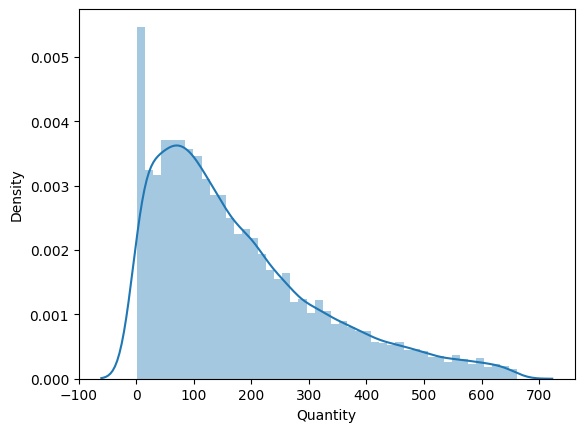

In [26]:
sns.distplot(data_ttl_trans[data_ttl_trans["Quantity"]<=661]["Quantity"])

<ipython-input-27-2f4854ef8e3d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ttl_trans[data_ttl_trans["Total Price"]<=97779]["Total Price"])


<Axes: xlabel='Total Price', ylabel='Density'>

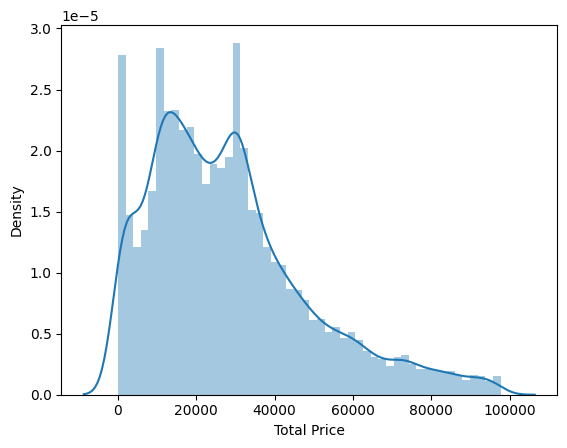

In [27]:
sns.distplot(data_ttl_trans[data_ttl_trans["Total Price"]<=97779]["Total Price"])

<Axes: ylabel='Quantity'>

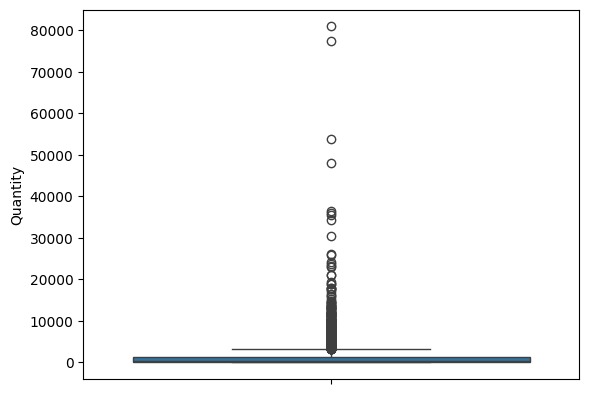

In [28]:
sns.boxplot(data_ttl_item["Quantity"])

In [29]:
print("Quantity upper",np.percentile(data_ttl_item["Quantity"],75)*2.5-np.percentile(data_ttl_item["Quantity"],25)) #箱线图顶点

Quantity upper 3279.75


In [30]:
data_ttl_item[data_ttl_item["Quantity"]<=2379].shape[0]/data_ttl_item.shape[0]

0.8555722138930535

<ipython-input-31-e71d7f1570a7>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ttl_item[data_ttl_item["Quantity"]<=2379]["Quantity"])


<Axes: xlabel='Quantity', ylabel='Density'>

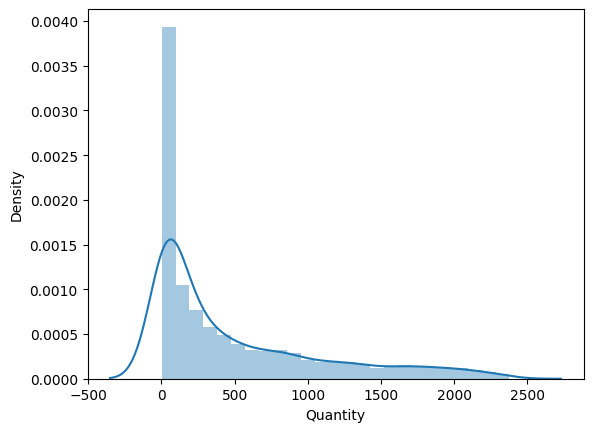

In [31]:
sns.distplot(data_ttl_item[data_ttl_item["Quantity"]<=2379]["Quantity"])

<p><span style="color: #ff9900;">The same situation for commodity-based data, with a clear right-leaning trend overall</span></p>

In [32]:
data_ttl_time.index = [str(i)+"\n"+str(j) for i,j in zip(data_ttl_time["Year"],data_ttl_time["Month"])]

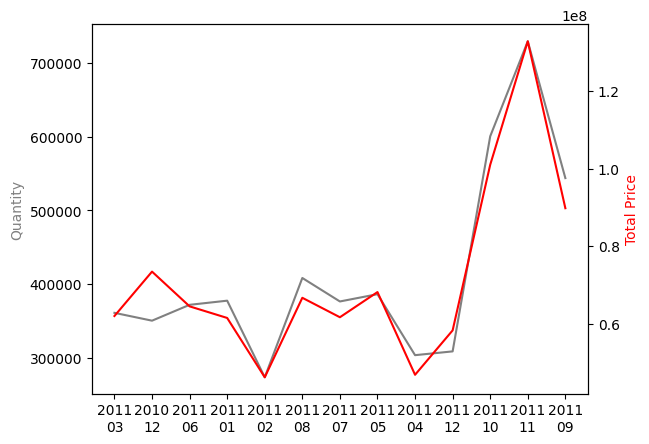

In [33]:
fig,ax1 = plt.subplots()
ax1.plot(data_ttl_time["Quantity"],color='gray',label="Quantity")
ax2 = ax1.twinx()
ax2.plot(data_ttl_time["Total Price"],color="red",label="Total Price")
ax1.set_ylabel("Quantity",color="gray")
ax2.set_ylabel("Total Price",color="red")
plt.show()

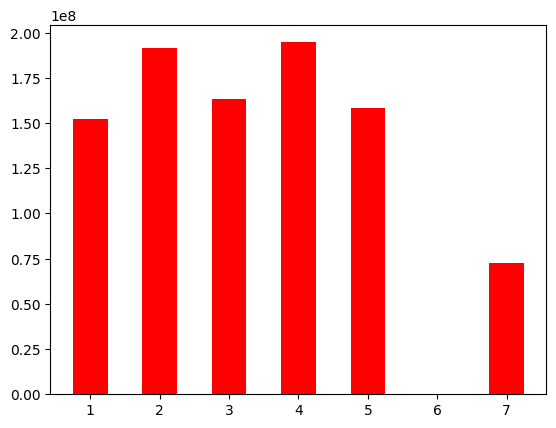

In [34]:
plt.bar(data_ttl_weekday["DayOfWeek"],data_ttl_weekday["Total Price"],color='red',width=0.5,label="Quantity")
plt.show()

<p><span style="color: #ff9900;">In terms of time trend, sales showed a clear upward trend and peaked in November 2011, before falling back in December.</span></p>

In [35]:
data_ttl_country.index = data_ttl_country["Country"]

In [36]:
ttl_price_country = data_ttl_country["Total Price"].sort_values()[::-1]

In [37]:
tmp = ttl_price_country[5:]
ttl_price_country = ttl_price_country[0:5]
ttl_price_country["others"] = sum(tmp)

In [38]:
ttl_price_country

Country
United Kingdom    819672317.0
Netherlands        27211203.0
Germany            19413647.0
France             17667279.0
Australia          13586362.0
others             34793156.0
Name: Total Price, dtype: float64

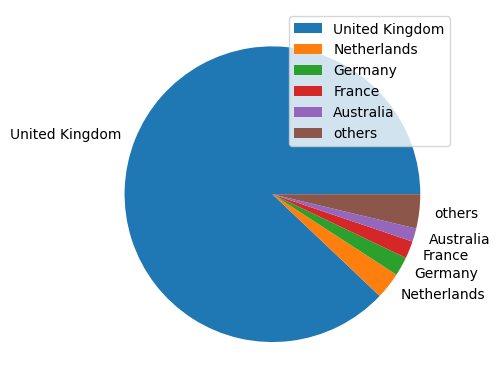

In [39]:
plt.pie(ttl_price_country,labels=ttl_price_country.index)
plt.legend(loc="upper right")
plt.show()

In [40]:
# data_ttl_country_time.index = data_ttl_country_time["Year"]+"\n"+data_ttl_country_time["Month"]
data_ttl_country_time["isUnitedKingdom"]=["UK" if i=="United Kingdom" else "Not UK" for i in data_ttl_country_time["Country"]]

In [41]:
data_ttl_country_time_isUK = data_ttl_country_time.groupby(["isUnitedKingdom","Year","Month"])["Total Price"].sum().reset_index()
data_ttl_country_time_isUK.index = data_ttl_country_time_isUK["Year"]+"\n"+data_ttl_country_time_isUK["Month"]

In [42]:
UK = data_ttl_country_time_isUK[data_ttl_country_time_isUK["isUnitedKingdom"]=="UK"]
NUK = data_ttl_country_time_isUK[data_ttl_country_time_isUK["isUnitedKingdom"]=="Not UK"]

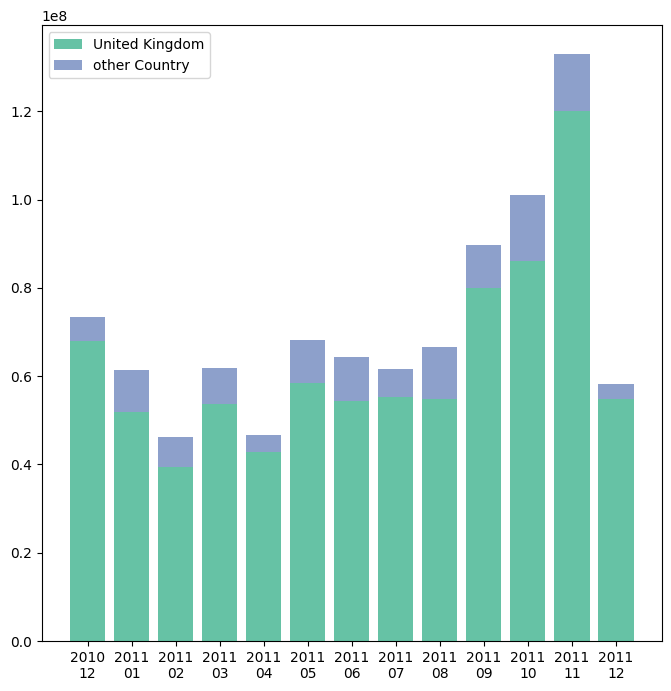

In [43]:
plt.figure(figsize=(8,8))
plt.bar(UK.index,UK["Total Price"],color="#66c2a5",label="United Kingdom")
plt.bar(NUK.index,NUK["Total Price"],bottom=UK["Total Price"],color="#8da0cb",label="other Country")
plt.legend()
plt.show()

<p><span style="color: #ff9900;">The UK accounts for significantly more sales than any other country at any given time, so the analysis below uses the full year 2011 data for the UK</span></p>

In [ ]:
## UK2011

In [44]:
df_UK = data.filter((F.col("Country")=="United Kingdom") & (F.col("Year")==2011))

In [45]:
df_UK.show(10)

+------+--------------------+--------+-------------------+-----+----------+--------------+----------+---------+----+------+----+-----+---+---------+-----------+
|BillNo|            Itemname|Quantity|               Date|Price|CustomerID|       Country|  Date_Day|Date_Time|Hour|Minute|Year|Month|Day|DayOfWeek|Total Price|
+------+--------------------+--------+-------------------+-----+----------+--------------+----------+---------+----+------+----+-----+---+---------+-----------+
|539993|JUMBO BAG PINK PO...|      10|2011-01-04 10:00:00|195.0|     13313|United Kingdom|04.01.2011|    10:00|  10|    00|2011|   01| 04|        2|     1950.0|
|539993|  BLUE POLKADOT WRAP|      25|2011-01-04 10:00:00| 42.0|     13313|United Kingdom|04.01.2011|    10:00|  10|    00|2011|   01| 04|        2|     1050.0|
|539993|  RED RETROSPOT WRAP|      25|2011-01-04 10:00:00| 42.0|     13313|United Kingdom|04.01.2011|    10:00|  10|    00|2011|   01| 04|        2|     1050.0|
|539993|RECYCLING BAG RET...|     

In [46]:
def transform_to_Season(x):
    if len(x)>1 and x[0]=="0":
        x = x[1:]
    return int((int(x)-1)//3)+1

In [47]:
df_UK = df_UK.withColumn("Season",F.udf(transform_to_Season,types.IntegerType())(F.col("Month")))

### <li><span style="color: #ff9900;">2-2 Exploring seasonal sensitive goods</span></li>

In [48]:
df_UK_seasonal = df_UK.groupby(["Season","Itemname"]).agg(F.countDistinct(F.col("BillNo")).alias("No_Of_Trans"),F.sum(F.col("Quantity")).alias("Quantity")
                                                         ,F.sum(F.col("Total Price")).alias("Total Price")).toPandas()

In [49]:
# rank model
def rank_seasonal(df,season="all"):
    groupby_cols = ["Itemname"]
    if season!="all":
        groupby_cols.append("Season")
        df = df[df["Season"]==int(season)]
    df = df.groupby(groupby_cols).sum(["No_Of_Trans","Quantity","Total Price"])
    for col in ["No_Of_Trans","Quantity","Total Price"]:
        df[col+"_Rank"]=df[col].rank(ascending=False)
    return df

df_UK_all = rank_seasonal(df_UK_seasonal)
df_UK_first = rank_seasonal(df_UK_seasonal,"1")
df_UK_second = rank_seasonal(df_UK_seasonal,"2")
df_UK_third = rank_seasonal(df_UK_seasonal,"3")
df_UK_fourth = rank_seasonal(df_UK_seasonal,"4")

In [51]:
## Top 10 Rank:
dfs = [df_UK_all,df_UK_first,df_UK_second,df_UK_third,df_UK_fourth]
item_set_No_Of_Trans=set()
item_set_Quantity=set()
item_set_Total_Price = set()
for df in dfs:
    df = df.copy().reset_index()
    itemname_top_Trans = df[df["No_Of_Trans_Rank"]<=10]["Itemname"]
    itemname_top_Qty = df[df["Quantity_Rank"]<=10]["Itemname"]
    itemname_top_TTL_PRICE = df[df["Total Price_Rank"]<=10]["Itemname"]
    for i in itemname_top_Trans:
        item_set_No_Of_Trans.add(i)
    for i in itemname_top_Qty:
        item_set_Quantity.add(i)
    for i in itemname_top_TTL_PRICE:
        item_set_Total_Price.add(i)

In [52]:
##
RANK_DF = {"Dimension":[],"item":[],"Rank":[],"Value":[],"Season":[],"Range":[]}#pd.DataFrame(columns=["Dimension","item","Rank","Value"])

for dim,itemset in [("No_Of_Trans",item_set_No_Of_Trans),("Quantity",item_set_Quantity),("Total Price",item_set_Total_Price)]:
    for i in list(itemset):
        min_rank=9999
        max_rank=-1
        for j,df in enumerate(dfs):
            df = df.reset_index()
            if j == 0:
                RANK_DF["Season"].append("all")
            else:
                RANK_DF["Season"].append(df["Season"].values[0])
            sub_df = df[df["Itemname"]==i]
            if sub_df.shape[0]==0:
                curr_rank=9999
                curr_value=0
            else:
                curr_rank = df[df["Itemname"]==i][dim+"_Rank"].values[0]
                curr_value = df[df["Itemname"]==i][dim].values[0]
            min_rank = min(curr_rank,min_rank)
            max_rank = max(curr_rank,max_rank) if curr_rank<9999 else max_rank
            RANK_DF["Dimension"].append(dim)
            RANK_DF["item"].append(i)
            RANK_DF["Rank"].append(curr_rank)
            RANK_DF["Value"].append(curr_value)
        RANK_DF["Range"] += [max_rank-min_rank]*5
RANK_DF = pd.DataFrame(RANK_DF)

<ipython-input-53-85991b1fe565>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df["Range_Rank"] = tmp_df["Range"].rank(ascending=False)
<ipython-input-53-85991b1fe565>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df["Range_Rank"] = tmp_df["Range"].rank(ascending=False)
<ipython-input-53-85991b1fe565>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

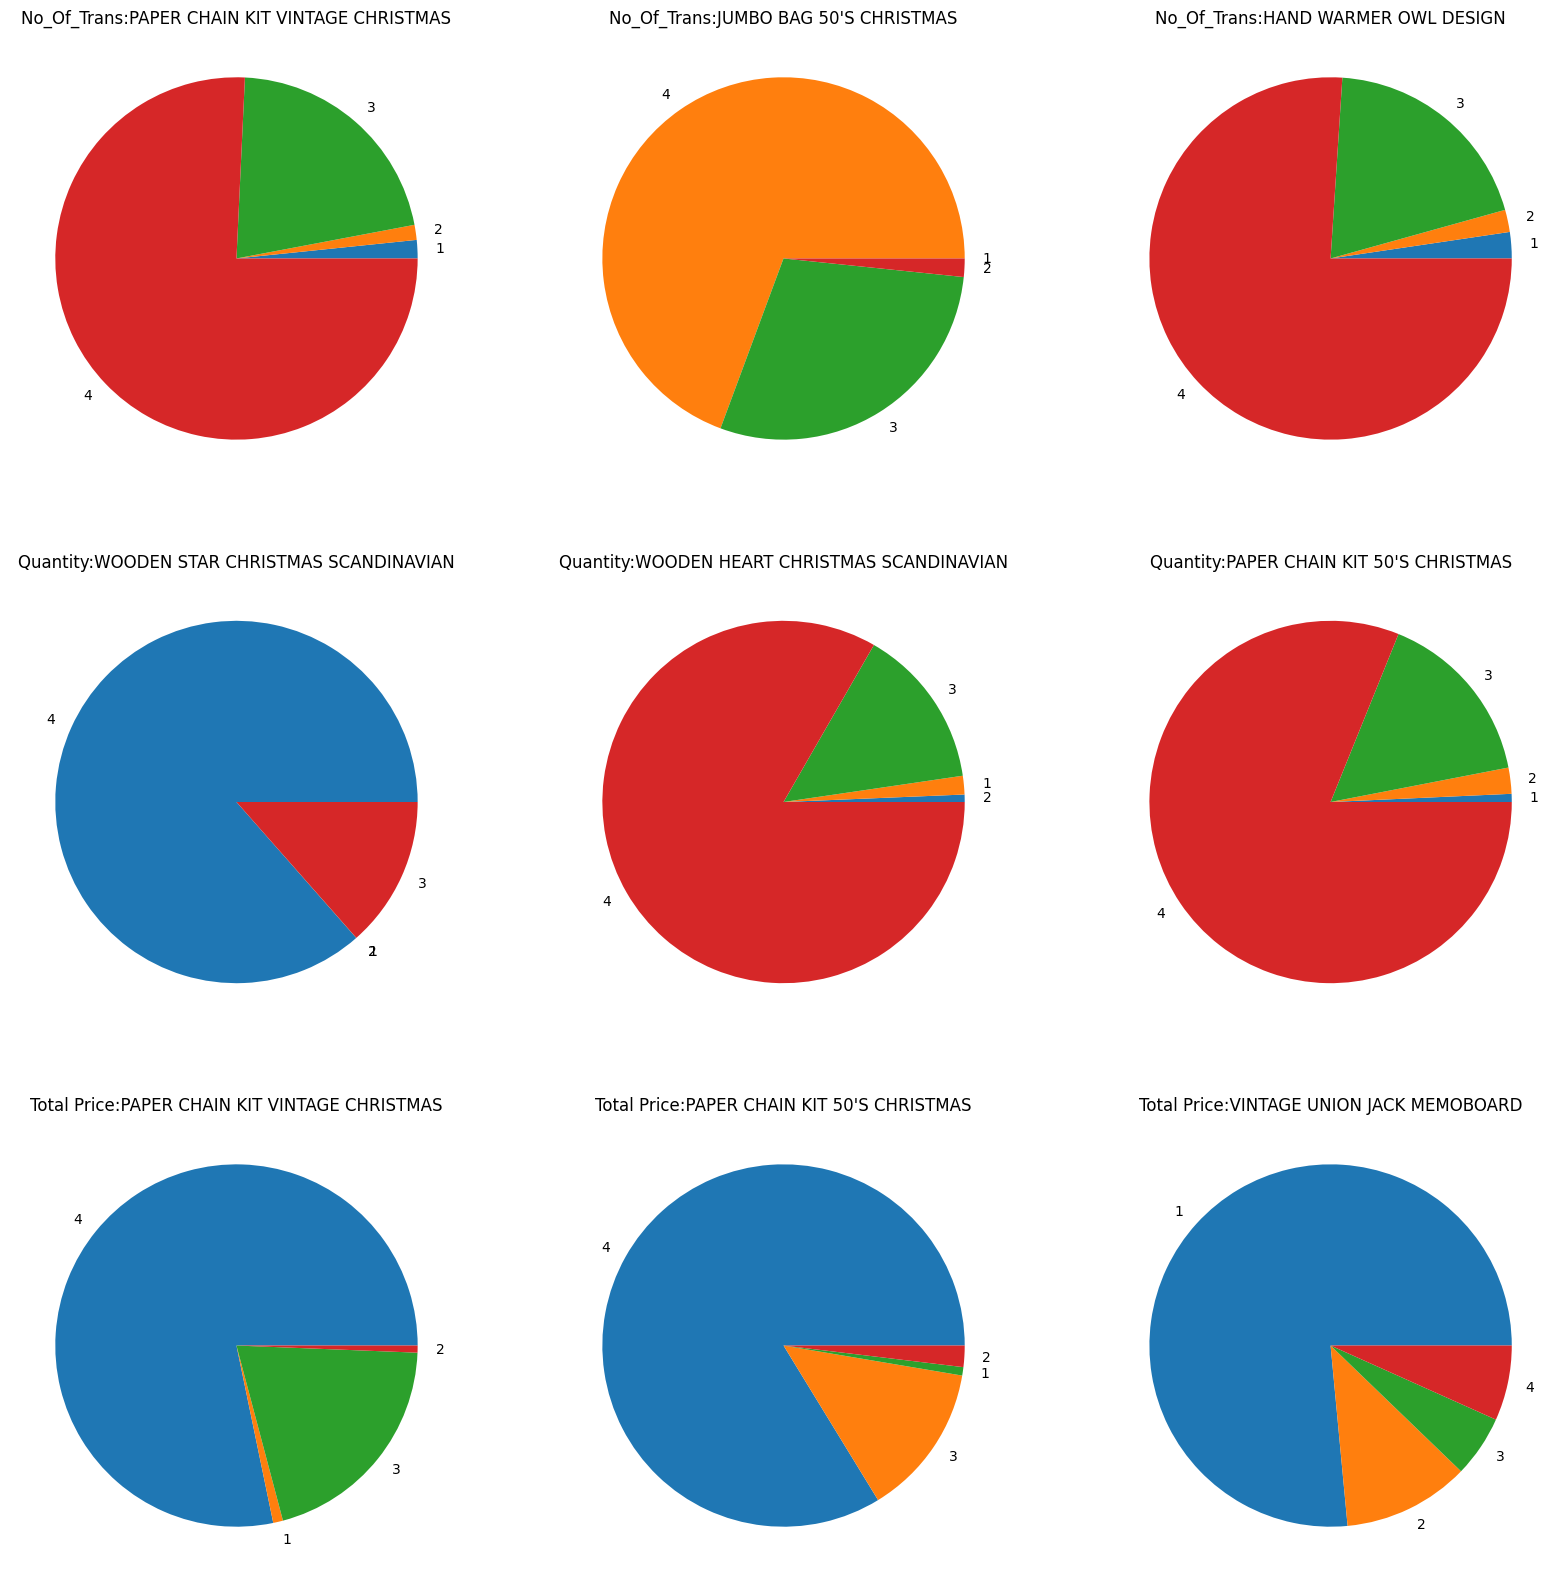

In [53]:
# RANK_DF.to_excel("Rank_Of_Seasons.xlsx",index=None)
plt.figure(figsize=(20,20))
#
dims = ["No_Of_Trans","Quantity","Total Price"]
for i,dim in enumerate(dims):
    tmp_df = RANK_DF[(RANK_DF["Dimension"]==dim) & (RANK_DF["Season"]!='all')]
    tmp_df["Range_Rank"] = tmp_df["Range"].rank(ascending=False)
    tmp_df = tmp_df.sort_values("Range_Rank").reset_index(drop=True)
    for j in range(3):
        tmp_df_rank = tmp_df.loc[4*j:4*(j+1)-1,:]
        this_item = list(set(tmp_df_rank["item"]))[0]
        plt.subplot(3,3,i*3+j+1)
        plt.pie(tmp_df_rank["Value"],labels=tmp_df_rank["Season"])
        plt.title(f"{dim}:{this_item}")
plt.show()

<p><span style="color: #ff9900;">The items shown in the chart above are among the top of the list in terms of total sales/Quantity/No of Transactions of all products, but are actually concentrated in a single quarter</span></p>

In [54]:
df_UK_monthly = df_UK.groupby(["Month","Itemname"]).agg(F.countDistinct(F.col("BillNo")).alias("No_Of_Trans"),F.sum(F.col("Quantity")).alias("Quantity")
                                                         ,F.sum(F.col("Total Price")).alias("Total Price")).toPandas().reset_index(drop=True)

In [55]:
df_UK_fullyear = df_UK_monthly.groupby(["Itemname"]).mean(["No_Of_Trans","Quantity","Total Price"]).reset_index()
df_UK_fullyear.rename(columns={"No_Of_Trans":"FY_No_Of_Trans","Quantity":"FY_Quantity","Total Price":"FY_Total Price"},inplace=True)

df_UK_Monthly_season = pd.merge(df_UK_monthly,df_UK_fullyear,on=["Itemname"],how='left')
df_UK_Monthly_season["seasonal_index_No_Of_Trans"]=df_UK_Monthly_season["No_Of_Trans"]/df_UK_Monthly_season["FY_No_Of_Trans"]
df_UK_Monthly_season["seasonal_index_Quantity"]=df_UK_Monthly_season["Quantity"]/df_UK_Monthly_season["FY_Quantity"]
df_UK_Monthly_season["seasonal_index_Total Price"]=df_UK_Monthly_season["Total Price"]/df_UK_Monthly_season["FY_Total Price"]

In [56]:


df_UK_season_max = df_UK_Monthly_season.groupby("Itemname").max(["seasonal_index_No_Of_Trans","seasonal_index_Quantity","seasonal_index_Total Price"]).reset_index().rename(columns={"seasonal_index_No_Of_Trans":"seasonal_index_No_Of_Trans_max","seasonal_index_Quantity":"seasonal_index_Quantity_max","seasonal_index_Total Price":"seasonal_index_Total Price_max"})
df_UK_season_min = df_UK_Monthly_season.groupby("Itemname").min(["seasonal_index_No_Of_Trans","seasonal_index_Quantity","seasonal_index_Total Price"]).reset_index().rename(columns={"seasonal_index_No_Of_Trans":"seasonal_index_No_Of_Trans_min","seasonal_index_Quantity":"seasonal_index_Quantity_min","seasonal_index_Total Price":"seasonal_index_Total Price_min"})
df_UK_season_ranges = pd.merge(df_UK_season_min,df_UK_season_max,on=["Itemname"])
seasonal_index_cols = ["seasonal_index_No_Of_Trans","seasonal_index_Quantity","seasonal_index_Total Price"]
for col in seasonal_index_cols:
    df_UK_season_ranges[col] = df_UK_season_ranges[col+"_max"]-df_UK_season_ranges[col+"_min"]
    df_UK_season_ranges[col+"_Rank"]=df_UK_season_ranges[col].rank(ascending=False)
df_UK_season_ranges = df_UK_season_ranges[["Itemname"]+[i for i in df_UK_season_ranges if "seasonal_index" in i]]

In [57]:
df_UK_season_ranges

,Itemname,seasonal_index_No_Of_Trans_min,seasonal_index_Quantity_min,seasonal_index_Total Price_min,seasonal_index_No_Of_Trans_max,seasonal_index_Quantity_max,seasonal_index_Total Price_max,seasonal_index_No_Of_Trans,seasonal_index_No_Of_Trans_Rank,seasonal_index_Quantity,seasonal_index_Quantity_Rank,seasonal_index_Total Price,seasonal_index_Total Price_Rank
0,"""ASSORTED FLOWER COLOUR """"LEIS""""""",0.121212,0.070227,0.093529,2.303030,2.547184,2.577934,2.181818,912.5,2.476957,1407.0,2.484404,1227.0
1,"""CHARLIE+LOLA""""EXTREMELY BUSY"""" SIGN""",0.217822,0.038462,0.232161,2.178218,4.038462,2.610523,1.960396,1186.0,4.000000,451.0,2.378362,1326.0
2,"""FLOWER GLASS GARLAND NECKL.36""""BLACK""",1.000000,0.363636,0.039357,1.000000,1.454545,1.584257,0.000000,3675.5,1.090909,3256.0,1.544900,2649.0
3,"""FLOWER GLASS GARLAND NECKL.36""""BLUE""",1.000000,0.555556,0.078890,1.000000,1.666667,2.381666,0.000000,3675.5,1.111111,3236.0,2.302776,1421.0
4,"""FLOWER GLASS GARLAND NECKL.36""""GREEN""",1.000000,0.500000,0.500000,1.000000,1.500000,1.500000,0.000000,3675.5,1.000000,3310.5,1.000000,3326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,ZINC T-LIGHT HOLDER STARS SMALL,0.420233,0.325399,0.404864,1.961089,2.366719,2.249812,1.540856,1880.0,2.041320,1972.0,1.844948,2134.0
3889,ZINC TOP 2 DOOR WOODEN SHELF,0.500000,0.454545,0.386757,3.000000,3.181818,3.452973,2.500000,645.0,2.727273,1169.5,3.066216,696.0
3890,ZINC WILLIE WINKIE CANDLE STICK,0.436364,0.276392,0.276376,2.454545,3.184261,3.575141,2.018182,1100.0,2.907869,1023.0,3.298765,576.0
3891,ZINC WIRE KITCHEN ORGANISER,0.357143,0.370370,0.116514,2.142857,2.962963,2.360146,1.785714,1441.5,2.592593,1281.0,2.243633,1504.0


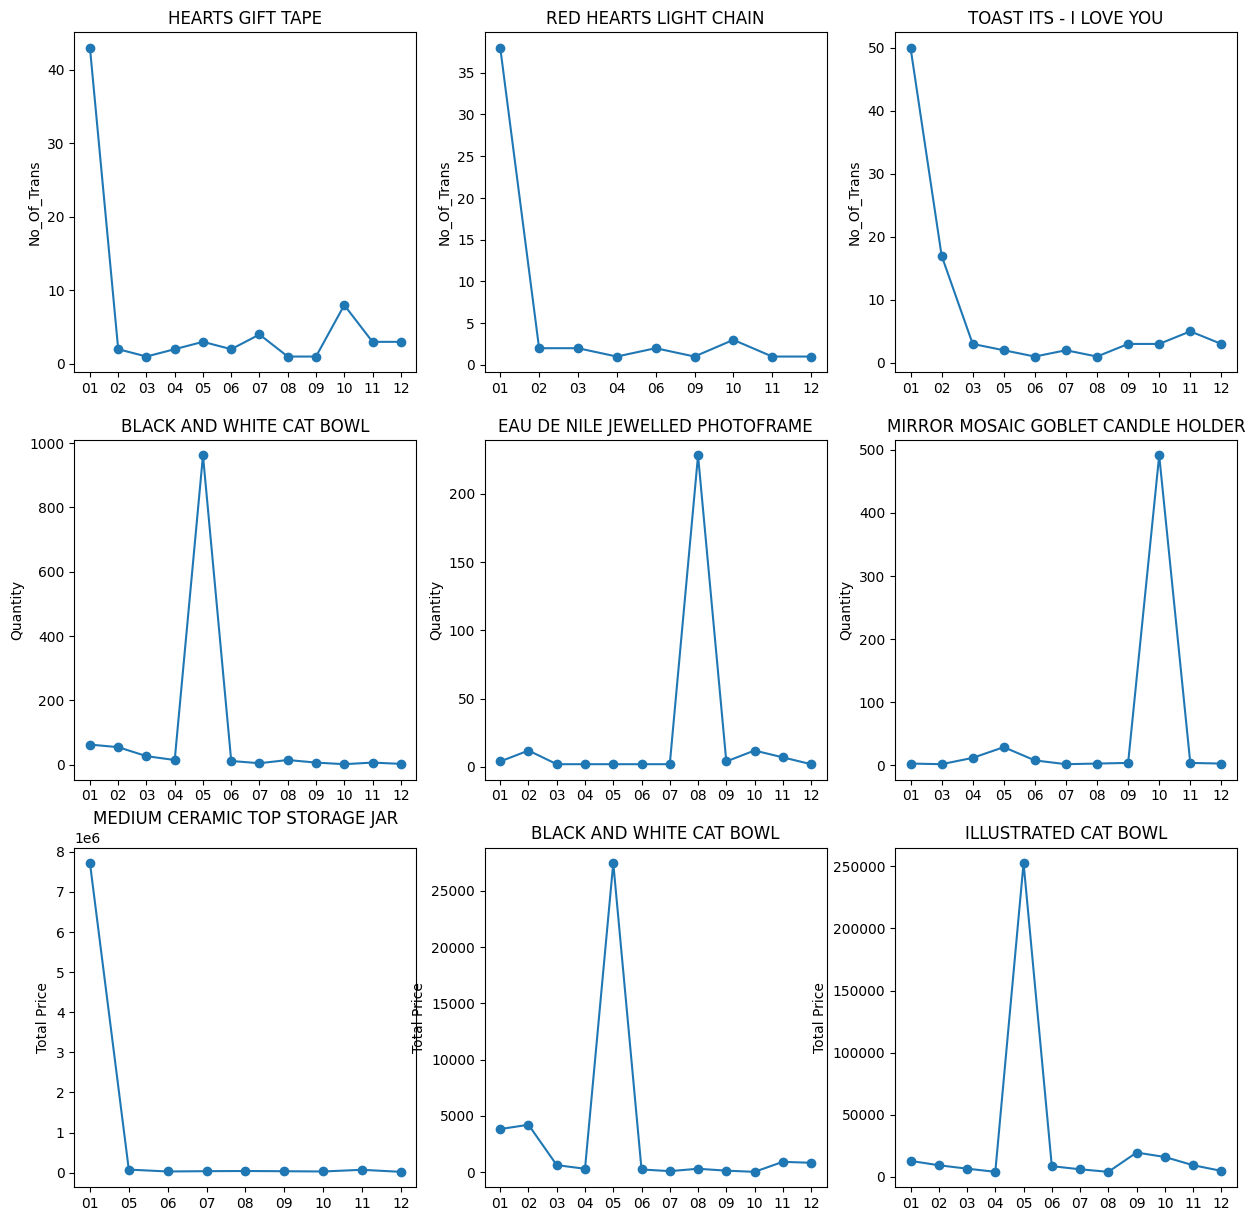

In [58]:
plt.figure(figsize=(15,15))
for i,col in enumerate(["seasonal_index_No_Of_Trans","seasonal_index_Quantity","seasonal_index_Total Price"]):
    seasonal_items = df_UK_season_ranges.sort_values(col+"_Rank").reset_index().loc[:2,"Itemname"].tolist()
    for j,item in enumerate(seasonal_items):
        plt.subplot(3,3,i*3+j+1)
        idxs = [k for k in df_UK_monthly.index if df_UK_monthly.loc[k,"Itemname"]==item]
        tmp_df = df_UK_monthly.loc[idxs,["Itemname","Month",col.replace("seasonal_index_","")]]
        tmp_df = tmp_df.pivot(index="Month",columns="Itemname",values=col.replace("seasonal_index_",""))
        plt.plot(tmp_df, marker='o')
        plt.ylabel(col.replace("seasonal_index_",""))
        plt.title(item)

plt.show()

<p><span style="color: #ff9900;">I constructed the "seasonal index" by dividing the monthly sales of each item by the annual sales.
As can be seen from the figure above, some products have obvious seasonal effects, and almost only sell well in a certain month.</span></p>

In [59]:
ranges = RANK_DF.groupby(["Dimension","item"]).first(["Range"]).reset_index()[["Dimension","item","Range"]]

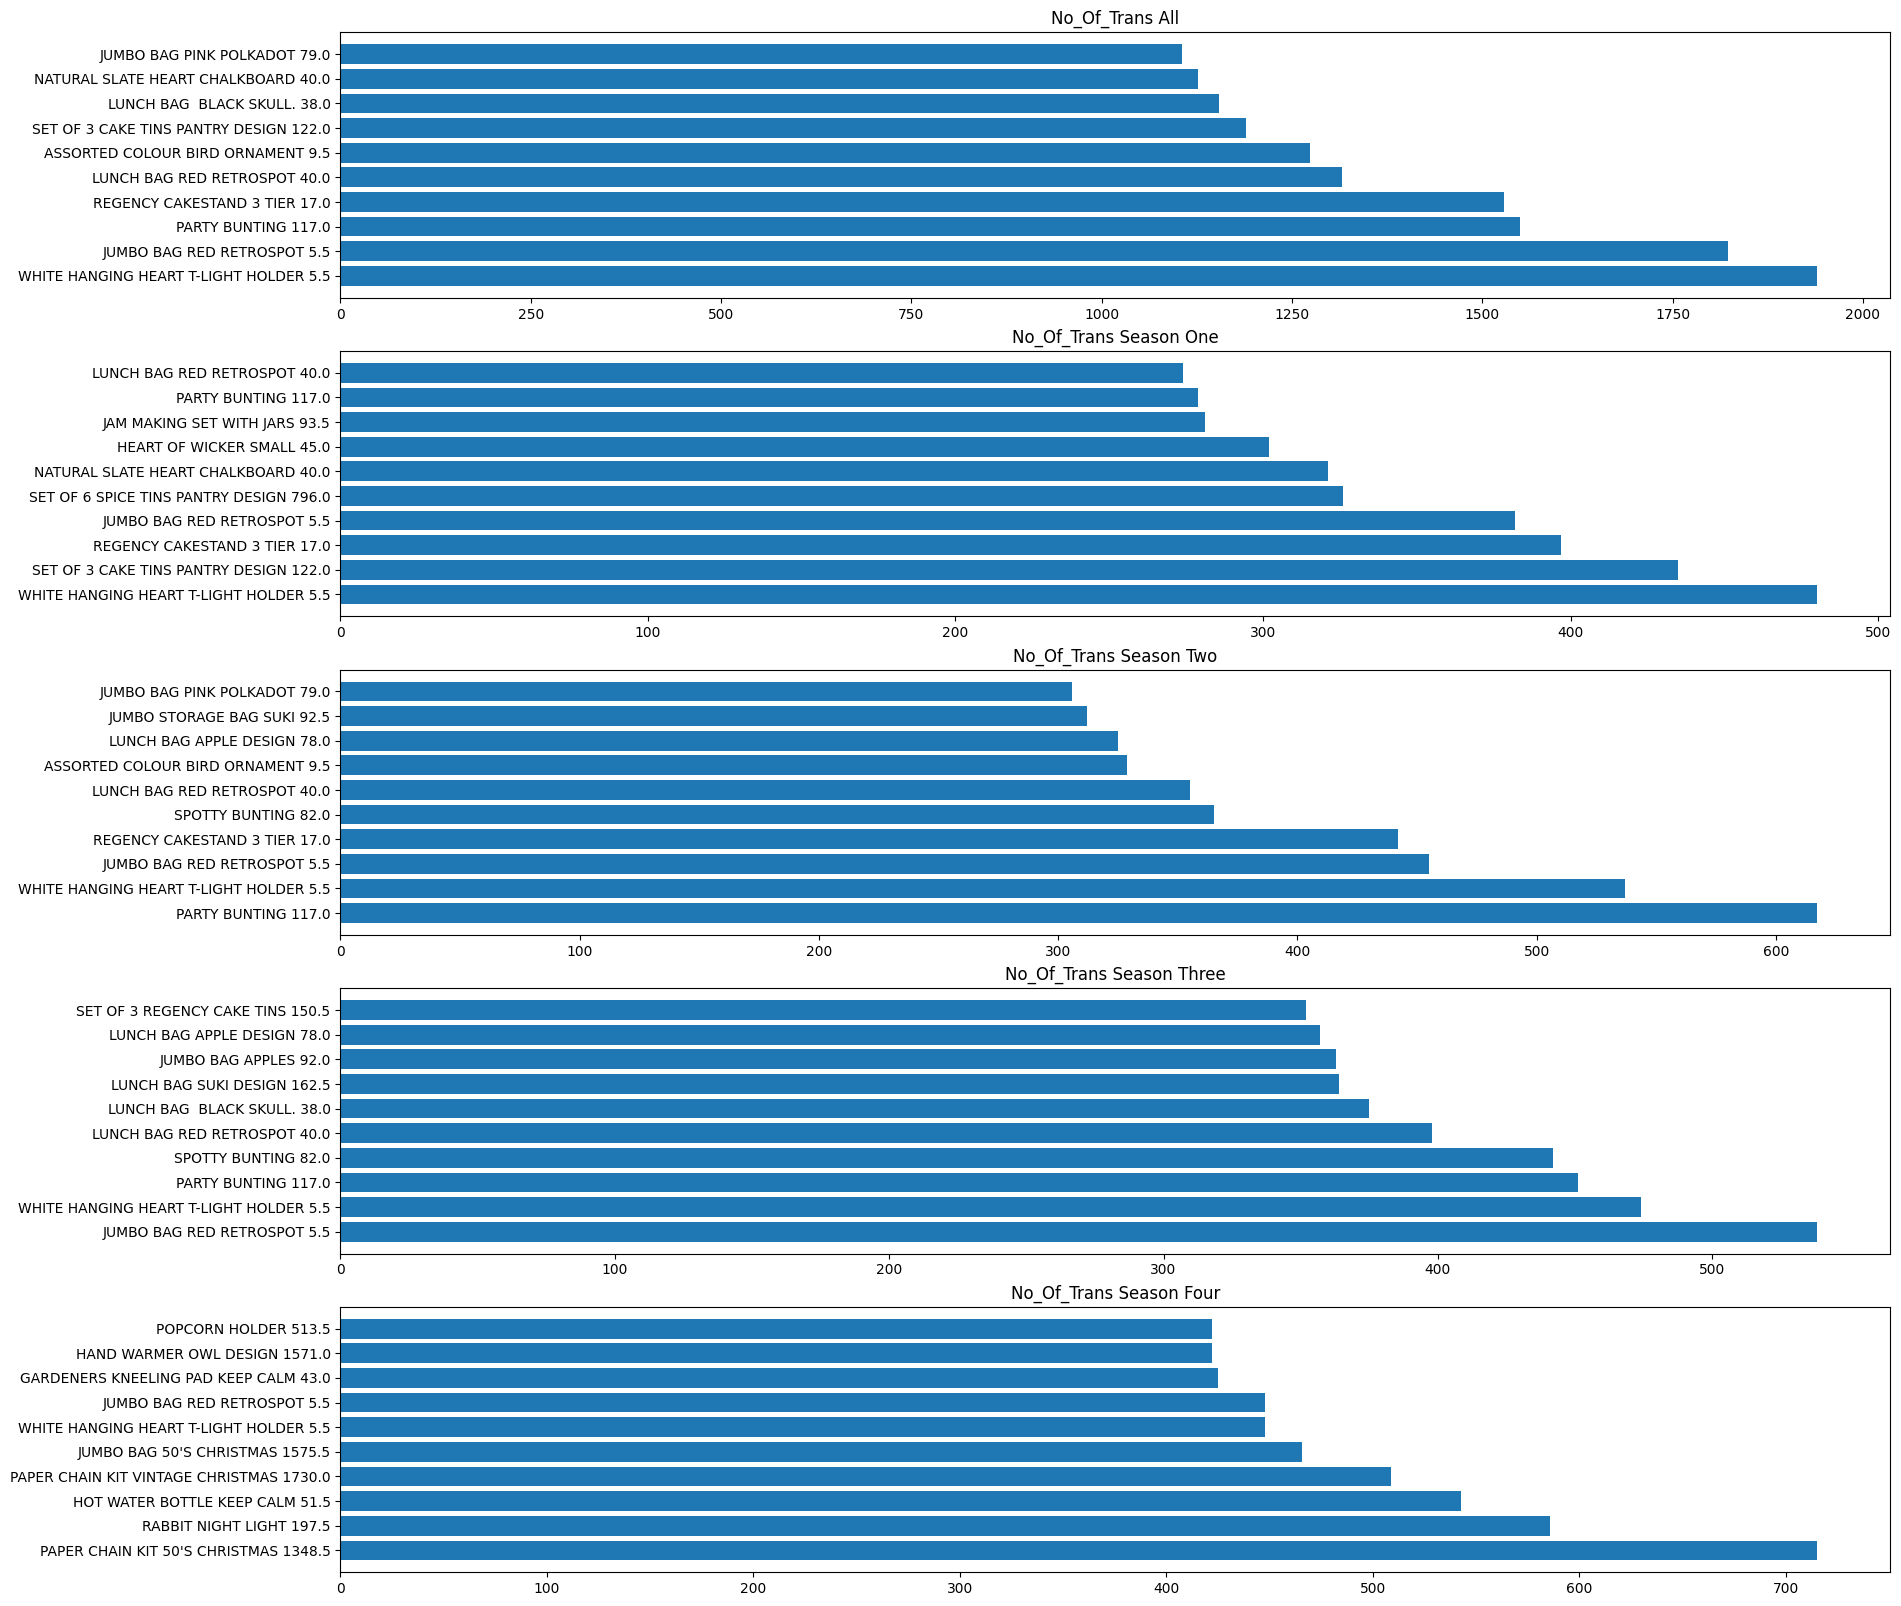

In [60]:
## No_Of_Trans
plt.figure(figsize=(20,20))
range_df = ranges[ranges["Dimension"]=="No_Of_Trans"]
titles = ["All","Season One","Season Two","Season Three","Season Four"]
for n in range(5):
    plt.subplot(5,1,n+1)
    df = dfs[n].copy().reset_index()
    df = df.loc[[i for i in df.index if df.loc[i,"Itemname"] in item_set_No_Of_Trans],["Itemname","No_Of_Trans"]]
    df=df.sort_values("No_Of_Trans",ascending=False)
    df = df.iloc[:10,:]
    df = pd.merge(df,range_df,left_on="Itemname",right_on="item",how="left")
    plt.barh(df["Itemname"]+" "+df["Range"].astype("str"),df["No_Of_Trans"])
    plt.title("No_Of_Trans "+titles[n])
plt.show()

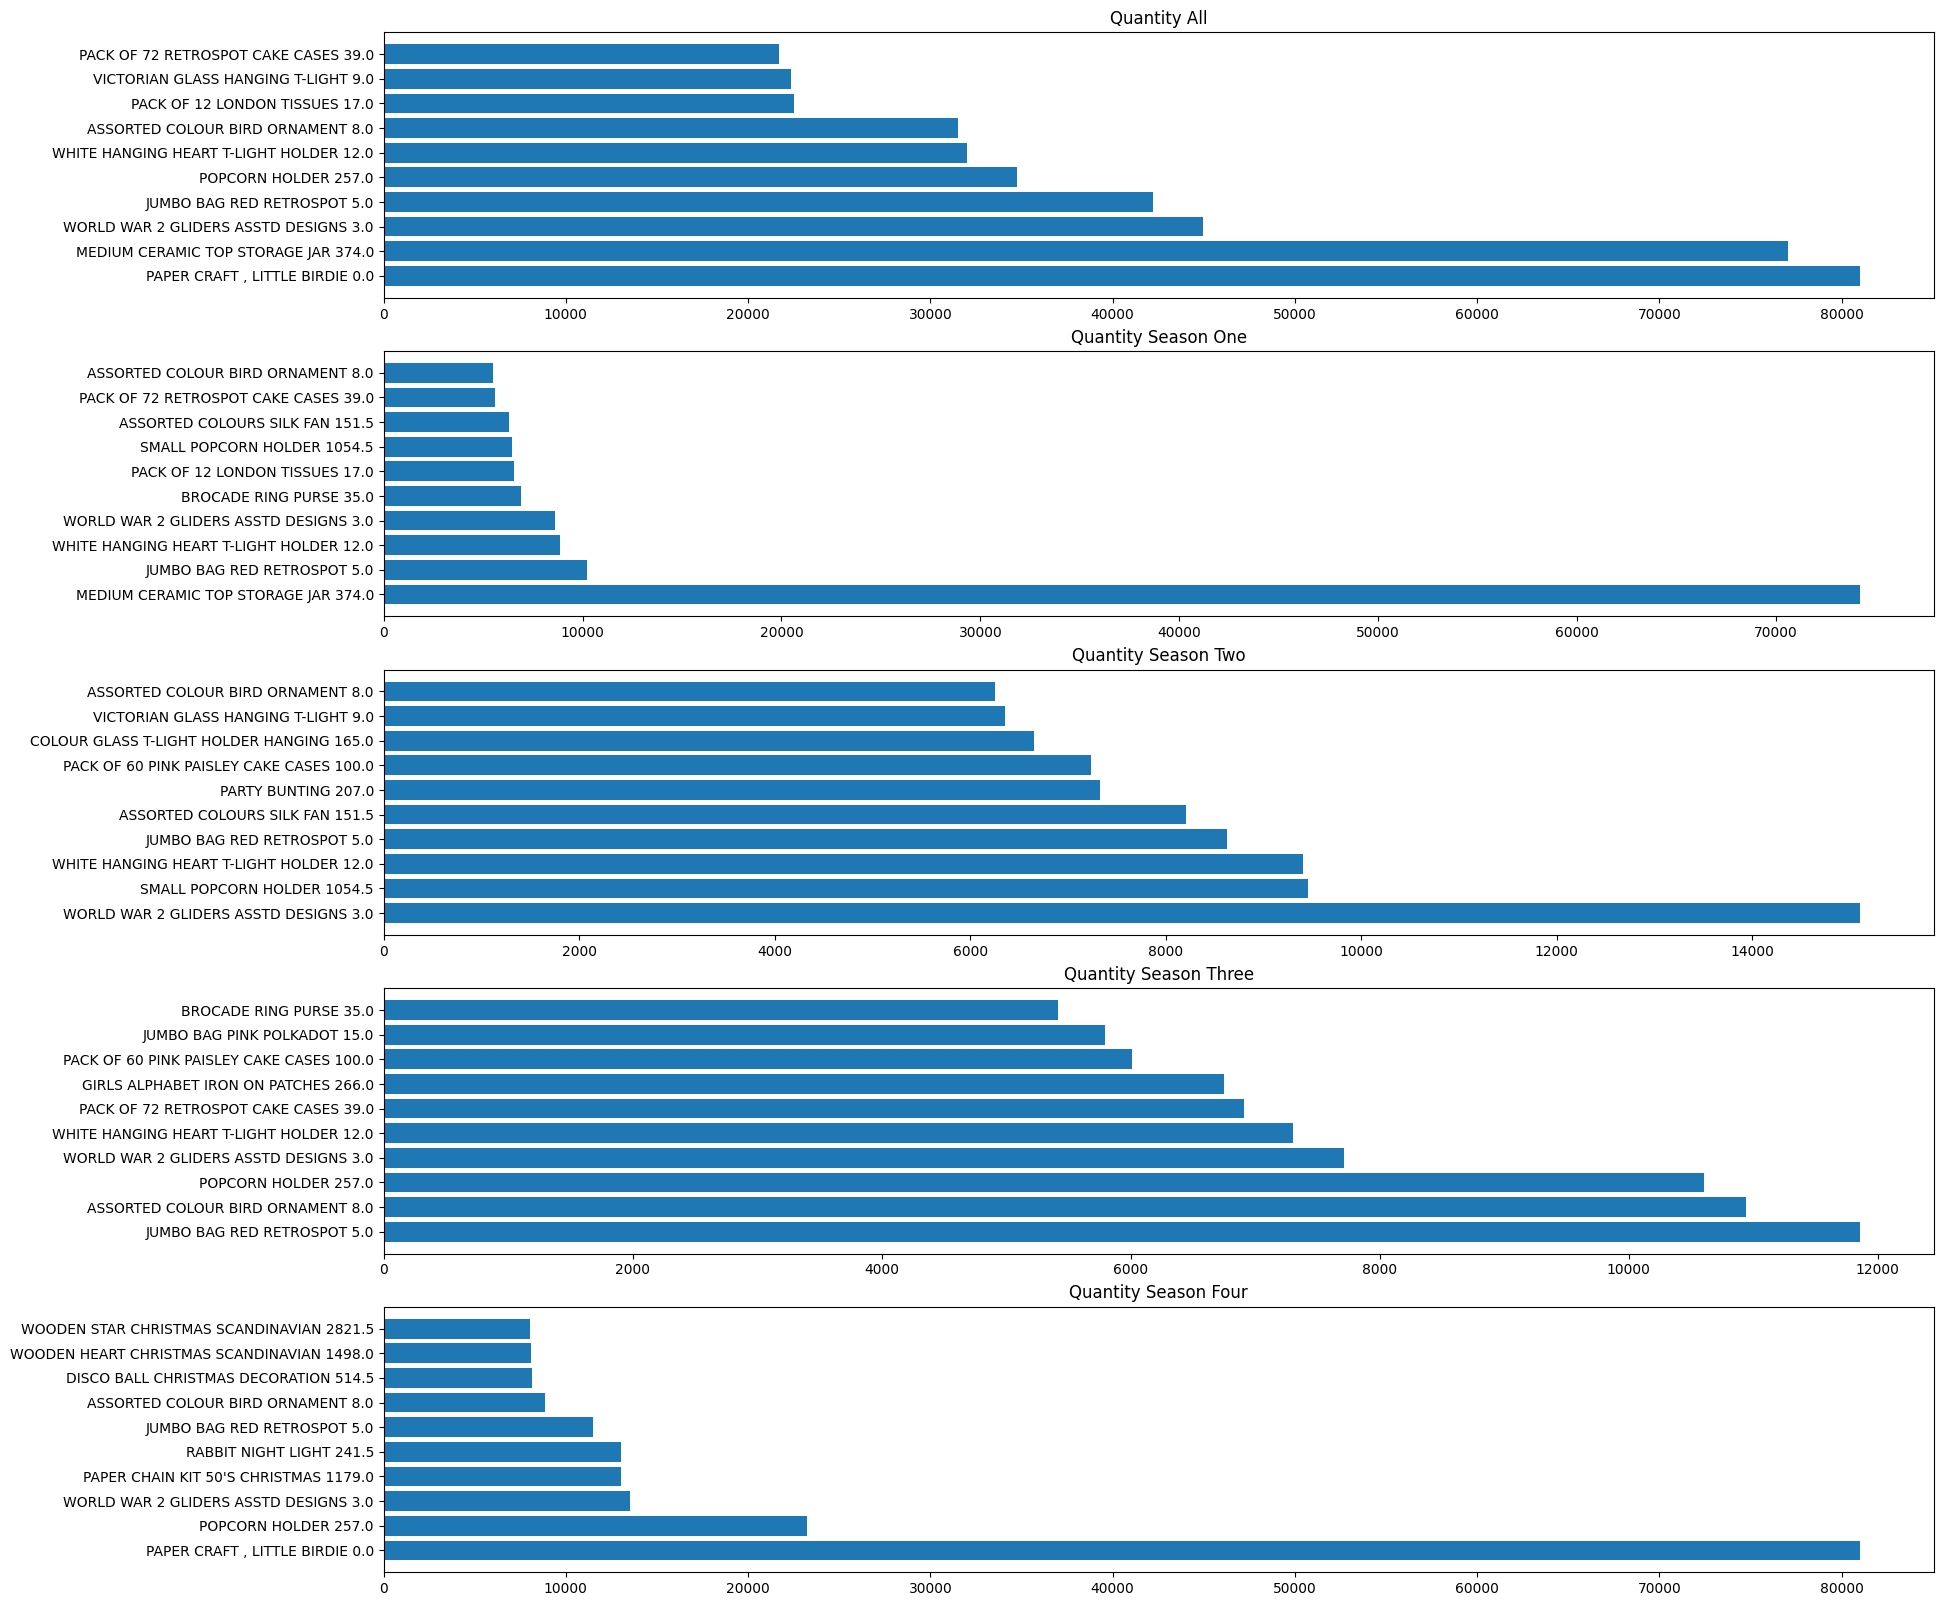

In [61]:
plt.figure(figsize=(20,20))
range_df = ranges[ranges["Dimension"]=="Quantity"]
titles = ["All","Season One","Season Two","Season Three","Season Four"]
for n in range(5):
    plt.subplot(5,1,n+1)
    df = dfs[n].copy().reset_index()
    df = df.loc[[i for i in df.index if df.loc[i,"Itemname"] in item_set_Quantity],["Itemname","Quantity"]]
    df=df.sort_values("Quantity",ascending=False)
    df = df.iloc[:10,:]
    df = pd.merge(df,range_df,left_on="Itemname",right_on="item",how="left")
    plt.barh(df["Itemname"]+" "+df["Range"].astype("str"),df["Quantity"])
    plt.title("Quantity "+titles[n])
plt.show()

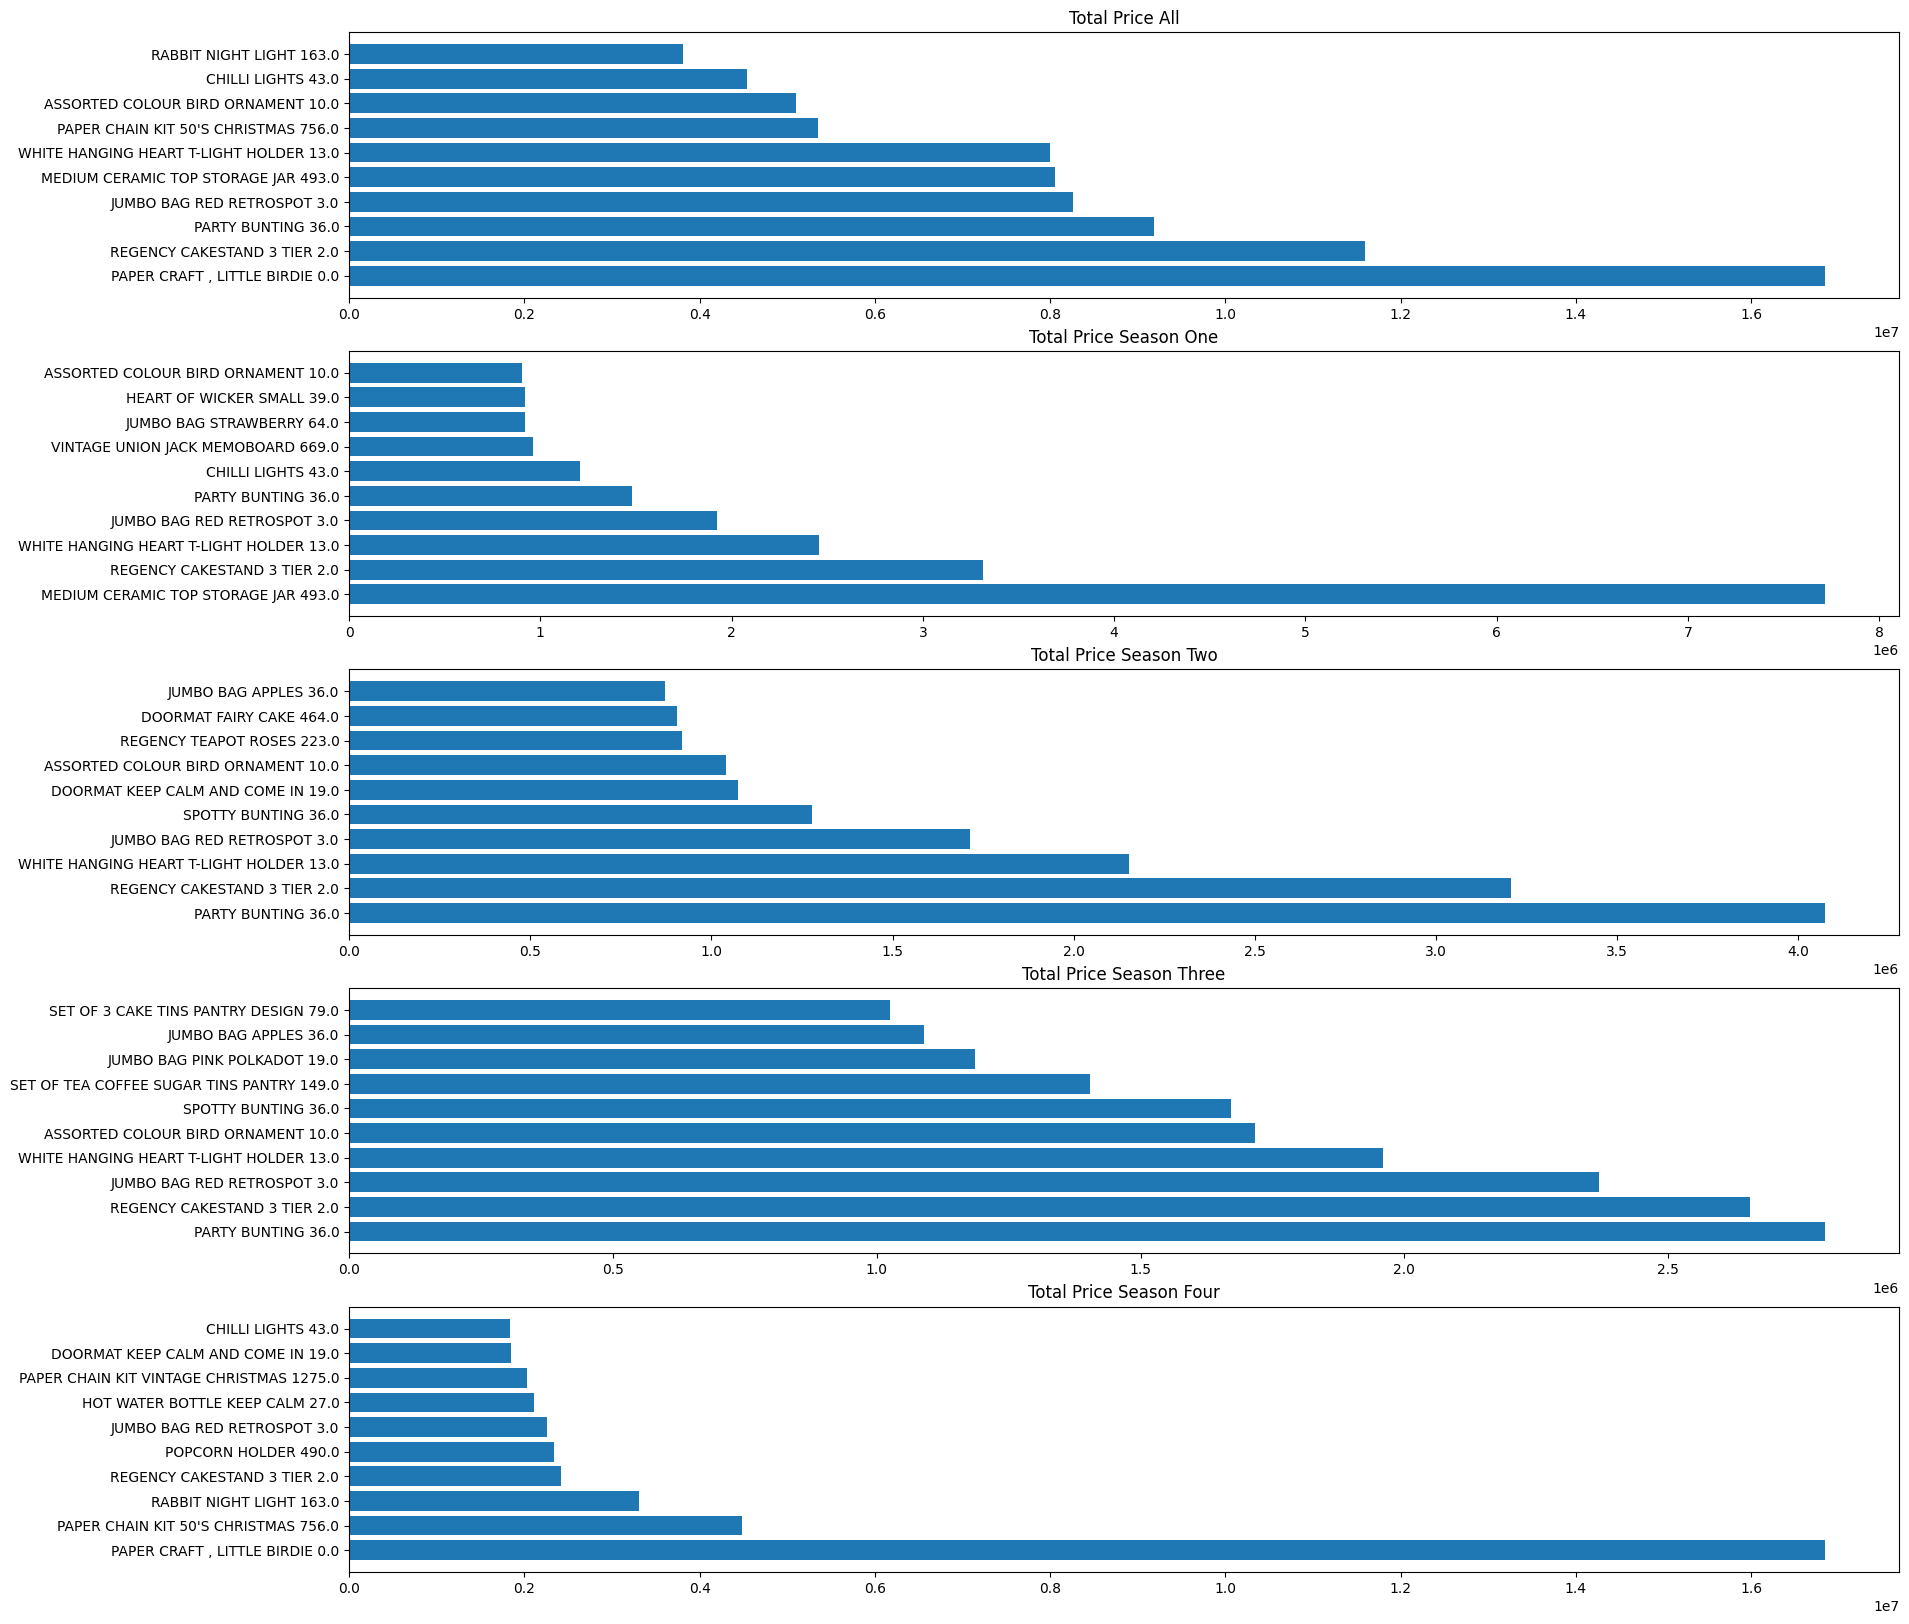

In [62]:
plt.figure(figsize=(20,20))
range_df = ranges[ranges["Dimension"]=="Total Price"]
titles = ["All","Season One","Season Two","Season Three","Season Four"]
for n in range(5):
    plt.subplot(5,1,n+1)
    df = dfs[n].copy().reset_index()
    df = df.loc[[i for i in df.index if df.loc[i,"Itemname"] in item_set_Total_Price],["Itemname","Total Price"]]
    df=df.sort_values("Total Price",ascending=False)
    df = df.iloc[:10,:]
    df = pd.merge(df,range_df,left_on="Itemname",right_on="item",how="left")
    plt.barh(df["Itemname"]+" "+df["Range"].astype("str"),df["Total Price"])
    plt.title("Total Price "+titles[n])
plt.show()

<p><span style="color: #ff9900;">As shown in the two charts above, the sales data are extremely unbalanced, with some sales far exceeding the normal sales.The outliers shown in the boxplot will be removed below.The three graphs above show the top 10 for the full year with No Of transactions, Quantity and Total Sales, and for each quarter. Notice the number next to the product name on the left, which is the ranking of the best selling quarter of the product minus the ranking of the worst selling quarter.</span></p>

### <li><span style="color: #ff9900;">2-3 Exploring goods with goods that perform differently in different dimensions </span></li>

In [63]:
df_UK_all = df_UK_monthly.groupby(["Itemname"]).sum(["No_Of_Trans","Quantity","Total Price"]).reset_index()
df_UK_all["No_Of_Trans_Rank"] = df_UK_all["No_Of_Trans"].rank(ascending=False)
df_UK_all["Quantity_Rank"] = df_UK_all["Quantity"].rank(ascending=False)
df_UK_all["Total Price_Rank"] = df_UK_all["Total Price"].rank(ascending=False)

In [64]:
df_UK_all

,Itemname,No_Of_Trans,Quantity,Total Price,No_Of_Trans_Rank,Quantity_Rank,Total Price_Rank
0,"""ASSORTED FLOWER COLOUR """"LEIS""""""",99,8202,400302.0,1350.5,82.0,443.0
1,"""CHARLIE+LOLA""""EXTREMELY BUSY"""" SIGN""",101,572,36436.0,1333.0,1478.0,2202.0
2,"""FLOWER GLASS GARLAND NECKL.36""""BLACK""",4,11,8029.0,3453.5,3464.5,3014.0
3,"""FLOWER GLASS GARLAND NECKL.36""""BLUE""",5,9,5007.0,3372.0,3528.0,3193.0
4,"""FLOWER GLASS GARLAND NECKL.36""""GREEN""",2,4,3180.0,3671.0,3699.5,3366.0
...,...,...,...,...,...,...,...
3888,ZINC T-LIGHT HOLDER STARS SMALL,257,4453,371747.0,460.0,211.0,477.0
3889,ZINC TOP 2 DOOR WOODEN SHELF,10,11,21913.0,3072.0,3464.5,2535.0
3890,ZINC WILLIE WINKIE CANDLE STICK,220,2084,200857.0,570.0,499.0,822.0
3891,ZINC WIRE KITCHEN ORGANISER,14,27,13389.0,2906.5,3150.5,2794.0


In [65]:
Rank_Gaps = [max(df_UK_all.loc[i,"No_Of_Trans_Rank"],df_UK_all.loc[i,"Quantity_Rank"],df_UK_all.loc[i,"Total Price_Rank"])\
             - min(df_UK_all.loc[i,"No_Of_Trans_Rank"],df_UK_all.loc[i,"Quantity_Rank"],df_UK_all.loc[i,"Total Price_Rank"])\
             for i in range(df_UK_all.shape[0])]
df_UK_all["Rank_Gaps"] = Rank_Gaps

In [66]:
df_ranked_all = df_UK_all.sort_values("Rank_Gaps",ascending=False).reset_index(drop=True)

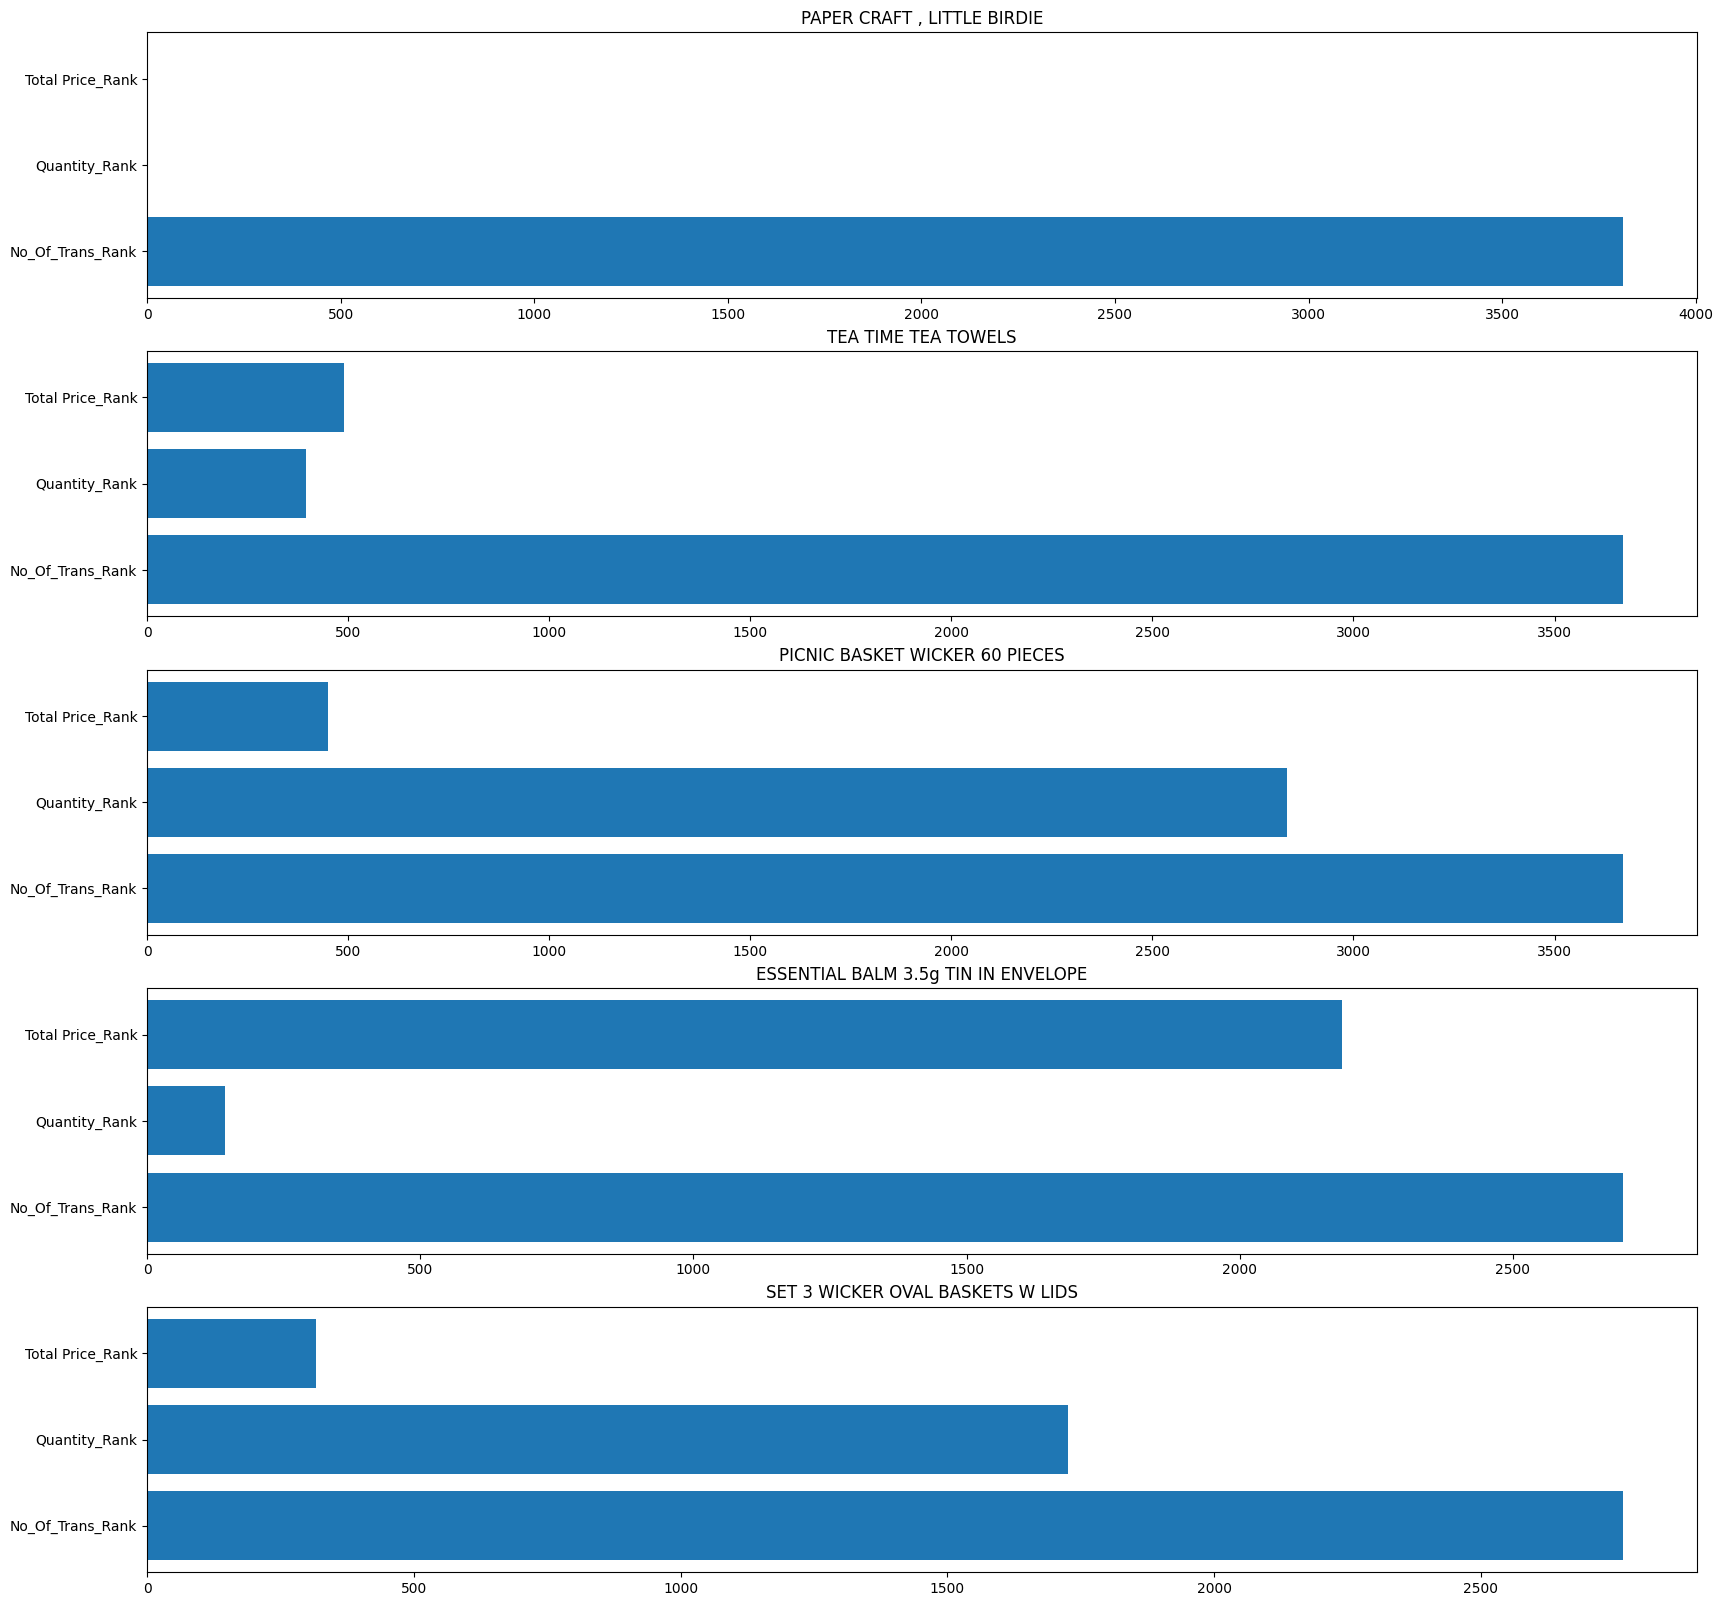

In [67]:
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(5,1,i+1)
    sub = df_ranked_all.iloc[i,:]
    item_name = sub["Itemname"]
    sub = dict(sub)
    sub_df = pd.DataFrame({"index":["No_Of_Trans_Rank","Quantity_Rank","Total Price_Rank"],\
                           "Value":[sub["No_Of_Trans_Rank"],sub["Quantity_Rank"],sub["Total Price_Rank"]]})
    plt.barh(sub_df["index"],sub_df["Value"])
    plt.title(item_name)
plt.show()

<p><span style="color: #ff9900;">I ranked the Total Sales, Quantity and No Of Transaction of each goods in the whole year, and listed the 5 goods with the biggest gap.</span><br /><span style="color: #ff9900;">Note: The lower the ranking, the larger sales/qty/no of trans</span></p>

### <li><span style="color: #ff9900;">2-4 Exploring UPT ASP ATV</span></li>

In [68]:
df_UK_monthly_KPI = df_UK_monthly.groupby(["Month"]).sum(["No_Of_Trans","Quantity","Total Price"]).reset_index()
df_UK_monthly_KPI["UPT"] = df_UK_monthly_KPI["Quantity"]/df_UK_monthly_KPI["No_Of_Trans"]
df_UK_monthly_KPI["ATV"] = df_UK_monthly_KPI["Total Price"]/df_UK_monthly_KPI["No_Of_Trans"]
df_UK_monthly_KPI["ASP"] = df_UK_monthly_KPI["Total Price"]/df_UK_monthly_KPI["Quantity"]

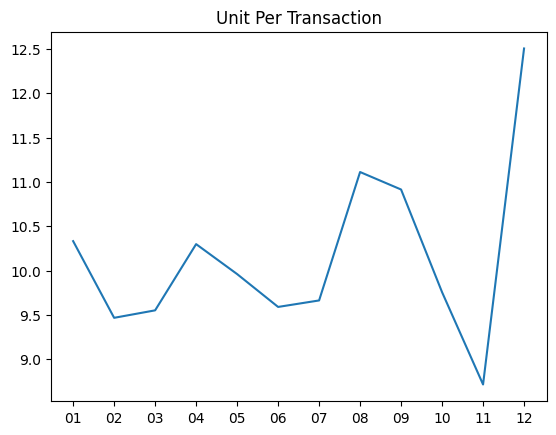

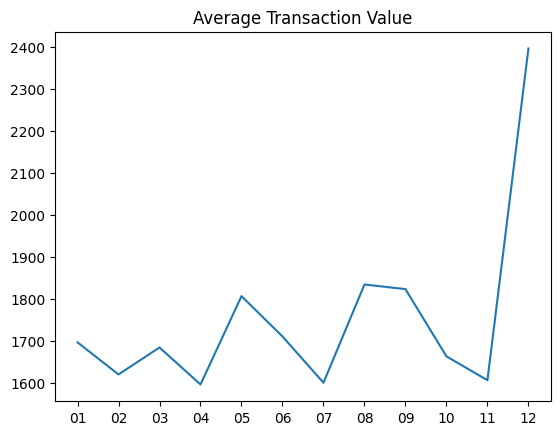

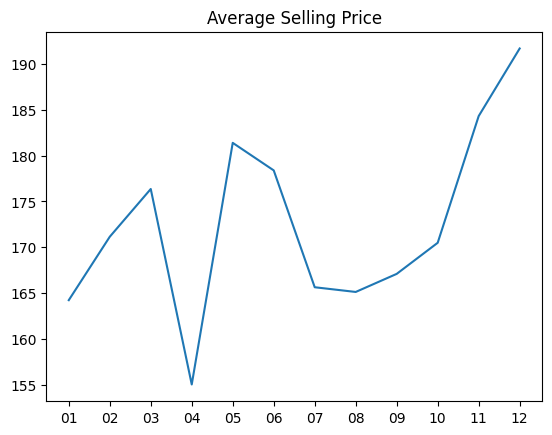

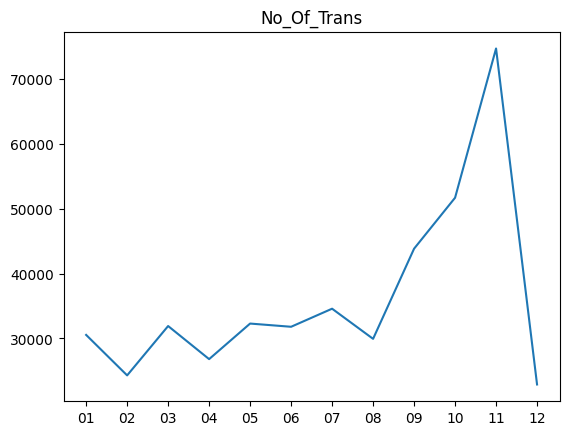

In [69]:
plt.plot(df_UK_monthly_KPI["Month"],df_UK_monthly_KPI["UPT"])
plt.title("Unit Per Transaction")
plt.show()
plt.plot(df_UK_monthly_KPI["Month"],df_UK_monthly_KPI["ATV"])
plt.title("Average Transaction Value")
plt.show()
plt.plot(df_UK_monthly_KPI["Month"],df_UK_monthly_KPI["ASP"])
plt.title("Average Selling Price")
plt.show()

plt.plot(df_UK_monthly_KPI["Month"],df_UK_monthly_KPI["No_Of_Trans"])
plt.title("No_Of_Trans")
plt.show()

<p><span style="color: #ff9900;">A very interesting conclusion can be drawn here.November's high sales were actually due to the high number of transactions in November.Despite the fact that sales dropped again by December, the December orders were actually big ones.</span></p>

### <li><span style="color: #ff9900;">2-5 (To be continue)Exploring Customer Sales</span></li>

In [70]:
df_monthly_CustomerID = df_UK.groupBy(["CustomerID","Month"]).agg(F.countDistinct(F.col("BillNo")).alias("No_Of_Trans"),F.sum(F.col("Quantity")).alias("Quantity")
                                                        ,F.sum(F.col("Total Price")).alias("Total Price")).toPandas()
df_by_CustomerID_by_Item = df_UK.groupBy(["CustomerID","Itemname"]).agg(F.countDistinct(F.col("BillNo")).alias("No_Of_Trans"),F.sum(F.col("Quantity")).alias("Quantity")
                                                        ,F.sum(F.col("Total Price")).alias("Total Price")).toPandas()

In [71]:
df_monthly_CustomerID["CustomerID"] = df_monthly_CustomerID["CustomerID"].astype(str)
df_monthly_CustomerID["isMember"] = [str(i)!='99999' for i in df_monthly_CustomerID["CustomerID"]]

df_monthly_Member = df_monthly_CustomerID[df_monthly_CustomerID["isMember"]==True].groupby("Month").sum(["No_Of_Trans","Total Price"]).sort_index()
df_monthly_Non_Member = df_monthly_CustomerID[df_monthly_CustomerID["isMember"]==False].reset_index()
df_monthly_Non_Member.index=df_monthly_Non_Member["Month"]
df_monthly_Non_Member = df_monthly_Non_Member.sort_index()

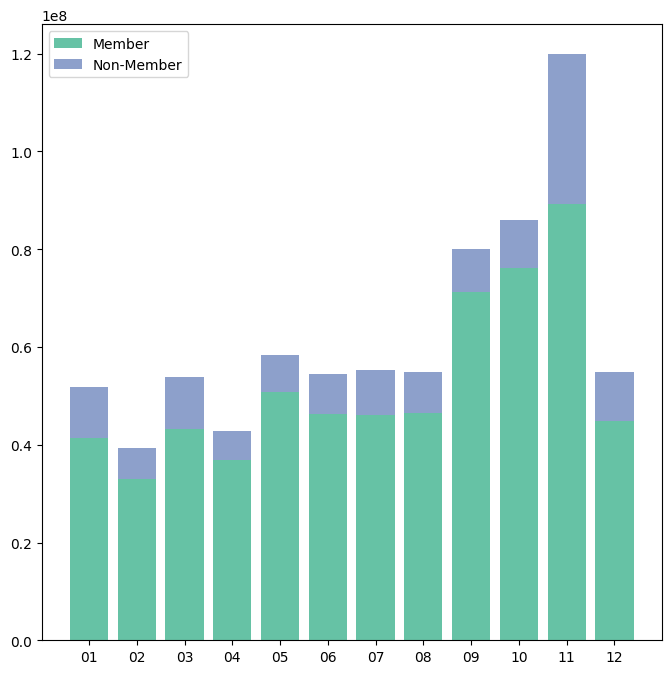

In [72]:
plt.figure(figsize=(8,8))
plt.bar(df_monthly_Member.index,df_monthly_Member["Total Price"],color="#66c2a5",label="Member")
plt.bar(df_monthly_Non_Member.index,df_monthly_Non_Member["Total Price"],bottom=df_monthly_Member["Total Price"],color="#8da0cb",label="Non-Member")
plt.legend()
plt.show()

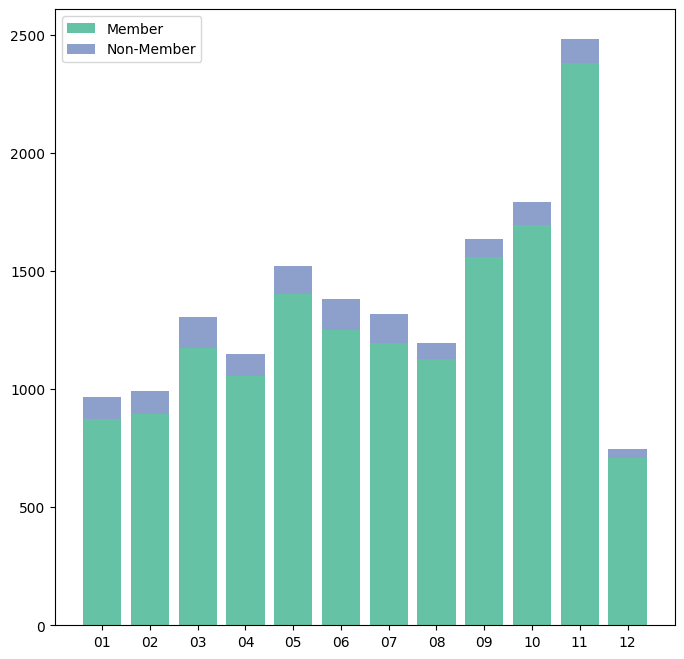

In [73]:
df_monthly_Member_No_of_Trans = df_monthly_CustomerID[df_monthly_CustomerID["isMember"]==True].groupby("Month").sum("No_Of_Trans").sort_index()
plt.figure(figsize=(8,8))
plt.bar(df_monthly_Member_No_of_Trans.index,df_monthly_Member_No_of_Trans["No_Of_Trans"],color="#66c2a5",label="Member")
plt.bar(df_monthly_Non_Member.index,df_monthly_Non_Member["No_Of_Trans"],bottom=df_monthly_Member_No_of_Trans["No_Of_Trans"],color="#8da0cb",label="Non-Member")
plt.legend()
plt.show()

<p><span style="color: #ff9900;">I treat any data with CustomerID as member data. But looking at the graph, most of the sales data comes from members. This conclusion is too counter-intuitive for me, so I didn't follow up with the corresponding analysis</span></p>

<a id="Association"></a>
## <li><span style="color: #ff9900;">3 Association Rules Exploring</span></li>

In [74]:
from pyspark.ml.fpm import FPGrowth,FPGrowthModel

In [75]:
# df_UK_pivot = df_UK.groupby("BillNo").pivot("ItemName").agg(F.count("*"))
df_UK_concatenated=df_UK.groupby(["BillNo","Itemname"]).agg(F.sum("Quantity").alias("Quantity")).groupby("BillNo").agg(F.collect_list(F.col("Itemname")).alias("items"))

In [76]:
model = FPGrowth(minSupport=0.03,minConfidence=0.3)
model = model.fit(df_UK_concatenated.select("items"))

In [77]:
res = model.associationRules.toPandas()

In [78]:
res.head()

,antecedent,consequent,confidence,lift,support
0,[LUNCH BAG PINK POLKADOT],[LUNCH BAG RED RETROSPOT],0.547988,6.859839,0.032233
1,[LUNCH BAG PINK POLKADOT],[LUNCH BAG BLACK SKULL.],0.513932,7.336667,0.030229
2,[ALARM CLOCK BAKELIKE GREEN],[ALARM CLOCK BAKELIKE RED],0.641124,12.411134,0.030472
3,[JUMBO STORAGE BAG SUKI],[JUMBO BAG RED RETROSPOT],0.623120,5.630984,0.040245
4,[GARDENERS KNEELING PAD KEEP CALM],[GARDENERS KNEELING PAD CUP OF TEA],0.602450,13.233013,0.032840


In [79]:
import itertools

In [80]:
combs = [('confidence', 'lift', 'support'),('lift', 'support', 'confidence'),('support', 'confidence', 'lift')]

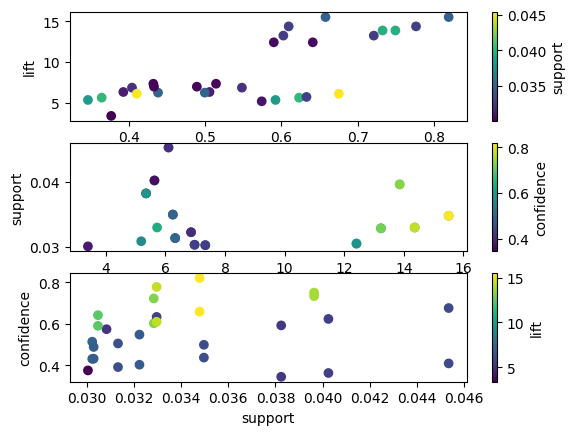

In [81]:
for i,(x,y,c) in enumerate(combs):
    plt.subplot(3,1,i+1)
    sc = plt.scatter(res[x],res[y],c=res[c],cmap='viridis')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(sc,label=c)
plt.show()

In [82]:
res.sort_values("support",ascending=False).head(6)

,antecedent,consequent,confidence,lift,support
15,[JUMBO BAG PINK POLKADOT],[JUMBO BAG RED RETROSPOT],0.675407,6.103485,0.045344
18,[JUMBO BAG RED RETROSPOT],[JUMBO BAG PINK POLKADOT],0.409764,6.103485,0.045344
3,[JUMBO STORAGE BAG SUKI],[JUMBO BAG RED RETROSPOT],0.623120,5.630984,0.040245
16,[JUMBO BAG RED RETROSPOT],[JUMBO STORAGE BAG SUKI],0.363686,5.630984,0.040245
5,[GREEN REGENCY TEACUP AND SAUCER],[ROSES REGENCY TEACUP AND SAUCER],0.749713,13.861696,0.039638
12,[ROSES REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.732884,13.861696,0.039638


<p><span style="color: #ff9900;">Support refers to the probability of 2 items appearing together in all orders.( $P(A \cap B)$ )<br>
The table above shows the top 3 combinations of support (every 2 rows of data are actually the same set).</span></p>

In [83]:
res.sort_values("confidence",ascending=False).head(5)

,antecedent,consequent,confidence,lift,support
28,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.819742,15.504521,0.034782
27,[PINK REGENCY TEACUP AND SAUCER],[ROSES REGENCY TEACUP AND SAUCER],0.776824,14.362962,0.032961
5,[GREEN REGENCY TEACUP AND SAUCER],[ROSES REGENCY TEACUP AND SAUCER],0.749713,13.861696,0.039638
12,[ROSES REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.732884,13.861696,0.039638
14,[GARDENERS KNEELING PAD CUP OF TEA],[GARDENERS KNEELING PAD KEEP CALM],0.721333,13.233013,0.032840


<p><span style="color: #ff9900;">Confidence refers to the probability that when item A occurs, item B will also occur.( $P(B|A) = \frac{P(A \cap B)}{P(A)} $ )<br>
The table above shows the top 5 combinations of confidence levels.</span></p>

In [84]:
res.sort_values("lift",ascending=False).head(6)

,antecedent,consequent,confidence,lift,support
28,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.819742,15.504521,0.034782
6,[GREEN REGENCY TEACUP AND SAUCER],[PINK REGENCY TEACUP AND SAUCER],0.657865,15.504521,0.034782
27,[PINK REGENCY TEACUP AND SAUCER],[ROSES REGENCY TEACUP AND SAUCER],0.776824,14.362962,0.032961
13,[ROSES REGENCY TEACUP AND SAUCER],[PINK REGENCY TEACUP AND SAUCER],0.609428,14.362962,0.032961
5,[GREEN REGENCY TEACUP AND SAUCER],[ROSES REGENCY TEACUP AND SAUCER],0.749713,13.861696,0.039638
12,[ROSES REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.732884,13.861696,0.039638


<p><span style="color: #ffcc99;">The lift indicates whether there is a positive/reverse relationship between the 2 commodity events.( $\frac{P(B|A)}{P(B)} = \frac{P(A \cap B)}{P(A)P(B)}$ )<br>
The table above shows the top 3 combinations of lift degree(every 2 rows of data are actually the same set).</span></p>

In [85]:
res.sort_values("lift",ascending=False)

,antecedent,consequent,confidence,lift,support
28,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.819742,15.504521,0.034782
6,[GREEN REGENCY TEACUP AND SAUCER],[PINK REGENCY TEACUP AND SAUCER],0.657865,15.504521,0.034782
27,[PINK REGENCY TEACUP AND SAUCER],[ROSES REGENCY TEACUP AND SAUCER],0.776824,14.362962,0.032961
13,[ROSES REGENCY TEACUP AND SAUCER],[PINK REGENCY TEACUP AND SAUCER],0.609428,14.362962,0.032961
5,[GREEN REGENCY TEACUP AND SAUCER],[ROSES REGENCY TEACUP AND SAUCER],0.749713,13.861696,0.039638
12,[ROSES REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.732884,13.861696,0.039638
14,[GARDENERS KNEELING PAD CUP OF TEA],[GARDENERS KNEELING PAD KEEP CALM],0.721333,13.233013,0.032840
4,[GARDENERS KNEELING PAD KEEP CALM],[GARDENERS KNEELING PAD CUP OF TEA],0.602450,13.233013,0.032840
2,[ALARM CLOCK BAKELIKE GREEN],[ALARM CLOCK BAKELIKE RED],0.641124,12.411134,0.030472
26,[ALARM CLOCK BAKELIKE RED],[ALARM CLOCK BAKELIKE GREEN],0.589894,12.411134,0.030472


<p><span style="color: #ffcc99;">
The table above is the result of sorting the lift value in descending order<br>
We found that the most common combinations of customers are different colored cups and saucers.<br>
Other products such as lunch bag,Jumbo Bag or alarm clock are also in the same situation.<br>
Overall, the most common combinations are the same product in different colors.
</span></p>

<a id="Conclusion"></a>
## <li><span style="color: #ff9900;">4 Conclusion</span></li>

<p><span style="color: #ff9900;">
1、Sales rose sharply in November and fell back in December<br>
2、The high volume of sales in November is due to the high volume of transactions in November, while in December, despite the relatively small volume of sales, virtually every transaction in December is a large transaction,with big Quantity and Price.<br>
3、Many products have seasonal effects, even those that rank in the top10 in terms of sales for the year(PAPER CHAIN KIT 50's CHRISMAS)<br>
4、Some products are far ahead of others in terms of sales, even though there are only a small number of transactions(such as PAPER CRAFT, LITTLE BIRDIE, which had only one transaction in 2011 but was the number one in sales).<br>
5、The most common combinations are the same product in different colors. The prime example are cups and saucers.
</span></p>